In [27]:
## Proyecto NBA
### Integrantes: Genaro, Oscar y Fabio
# Para garantizar que el proyecto de análisis de datos de la NBA se ejecute
# de manera óptima y sin conflictos con otras librerías o versiones 
# de Python que puedas tener en tu sistema, es esencial que crees un 
# entorno virtual. Un entorno virtual es un espacio aislado que te 
# permite instalar y administrar las dependencias de tu proyecto de 
# forma independiente. Y luego instalar las las librerias con pip o conda.

# pip install pymongo cassandra-driver py2neo pandas numpy matplotlib seaborn plotly ipywidgets requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pymongo
from pymongo import MongoClient
import json
import requests
import ipywidgets as widgets
import plotly.graph_objects as go




## Proyecto NBA
<br>
# Integrantes:
</br>

## Introducción al Proyecto de Análisis de Datos de la NBA

En la era moderna del deporte, el análisis de datos ha asumido un rol crucial, transformando la forma en que equipos, entrenadores, y aficionados entienden el juego. En el baloncesto, y específicamente en la NBA, este análisis se ha vuelto fundamental para descubrir insights que no son visibles a simple vista. Al examinar meticulosamente estadísticas y patrones de juego, los equipos pueden mejorar su estrategia, entrenamiento, y toma de decisiones en la cancha.

El proyecto que presentamos busca aprovechar el poder del análisis de datos en el contexto de la NBA. Utilizamos una combinación de bases de datos avanzadas - MongoDB, Cassandra y Neo4j - para abordar este desafío desde diferentes ángulos. Cada una de estas bases de datos ofrece características únicas que son esenciales para entender profundamente los aspectos multifacéticos del juego.

# MongoDB 
Una base de datos NoSQL, nos permite manejar grandes volúmenes de datos no estructurados. Esto es esencial para analizar estadísticas de jugadores y equipos, historiales de partidos, y otros datos en formatos variados. Su flexibilidad para manejar diferentes tipos de datos nos permite una exploración más libre y creativa, crucial en el análisis deportivo donde cada temporada trae nuevas tendencias y patrones.

# Cassandra
Por otro lado, brilla en el manejo de grandes cantidades de datos distribuidos, ofreciendo lecturas y escrituras rápidas. Esto es crucial para el análisis en tiempo real y para manejar grandes conjuntos de datos históricos, permitiéndonos identificar tendencias a lo largo del tiempo y entender mejor el rendimiento de los equipos y jugadores a lo largo de diferentes temporadas.

# Neo4j

Finalmente, Neo4j, una base de datos de grafos, nos permite analizar las complejas interacciones y relaciones dentro de los datos. En un deporte como el baloncesto, donde las relaciones entre jugadores, equipos, y entrenadores juegan un papel fundamental, Neo4j nos ayuda a visualizar y entender estas redes, revelando cómo las interacciones personales pueden influir en el rendimiento y la estrategia.

Al combinar estos enfoques y tecnologías, nuestro proyecto no solo busca responder preguntas existentes sobre estrategias de juego, rendimiento de jugadores y dinámicas de equipo, sino también descubrir nuevas preguntas y perspectivas. En última instancia, el análisis avanzado de datos de la NBA nos permite no solo entender mejor el juego tal como lo conocemos hoy, sino también anticipar y modelar el futuro del baloncesto profesional.

Aqui vamos a poner los codigo de como creamos las distintas base de datos: <br>
Nota: recuerda tener los contenedores prendidos para que los codigos funcione y tambien si corriste este codigo una vez no funcionara porque se va a reescribir los datos.

In [28]:
import requests
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017/')
#client = MongoClient('mongodb://mongo:27017/')
db = client['nba']
collection = db['player_data']

for season in range(2010, 2024):
    try:
        # Realizar la solicitud a la API
        response = requests.get(f'https://nba-stats-db.herokuapp.com/api/playerdata/season/{season}')
        response.raise_for_status()  # Esto lanzará una excepción si la solicitud no fue exitosa
        data = response.json()

        # Insertar datos en MongoDB si 'results' está presente en la respuesta
        if 'results' in data:
            collection.insert_many(data['results'])
        else:
            print(f"No se encontraron resultados para la temporada {season}")
    
    except requests.RequestException as e:
        print(f"Error de solicitud para la temporada {season}: {e}")
    except pymongo.errors.PyMongoError as e:
        print(f"Error al insertar documentos para la temporada {season}: {e}")

# Contar y mostrar el número de documentos en la colección
count = collection.count_documents({})
print(f"Total de documentos en la colección: {count}")




 



Total de documentos en la colección: 1400


In [30]:
##codigos de cassandra
from pymongo import MongoClient
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement

#mongo_client = MongoClient('mongodb://mongo:27017/')
mongo_client = MongoClient('mongodb://localhost:27017/')
mongo_db = mongo_client['nba']
mongo_collection = mongo_db['player_data']

# Conexión a Cassandra
#cluster = Cluster(['cassandra'], port=9042)

cluster = Cluster(['localhost'], port=9042)

session = cluster.connect()

# Crear keyspace y tabla si no existen
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS nba WITH replication = {
        'class': 'SimpleStrategy', 
        'replication_factor': '1'
    }
""")
session.execute("""
    CREATE TABLE IF NOT EXISTS nba.player_stats (
        id int PRIMARY KEY,
        player_name text,
        age int,
        games int,
        games_started int,
        minutes_played int,
        field_goals int,
        field_attempts int,
        field_percent text,
        three_fg int,
        three_attempts int,
        three_percent text,
        two_fg int,
        two_attempts int,
        two_percent text,
        effect_fg_percent text,
        ft int,
        fta int,
        ft_percent text,
        ORB int,
        DRB int,
        TRB int,
        AST int,
        STL int,
        BLK int,
        TOV int,
        PF int,
        PTS int,
        team text,
        season int
    )
""")

# Función para insertar datos en Cassandra
def insert_into_cassandra(data):
    prepared = session.prepare("""
        INSERT INTO nba.player_stats (id, player_name, age, games, games_started, minutes_played, field_goals, field_attempts, field_percent, three_fg, three_attempts, three_percent, two_fg, two_attempts, two_percent, effect_fg_percent, ft, fta, ft_percent, ORB, DRB, TRB, AST, STL, BLK, TOV, PF, PTS, team, season)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """)
    session.execute(prepared, (data['id'], data['player_name'], data['age'], data['games'], data['games_started'], data['minutes_played'], data['field_goals'], data['field_attempts'], data['field_percent'], data['three_fg'], data['three_attempts'], data['three_percent'], data['two_fg'], data['two_attempts'], data['two_percent'], data['effect_fg_percent'], data['ft'], data['fta'], data['ft_percent'], data['ORB'], data['DRB'], data['TRB'], data['AST'], data['STL'], data['BLK'], data['TOV'], data['PF'], data['PTS'], data['team'], data['season']))

# Transferir datos de MongoDB a Cassandra
for data in mongo_collection.find():
    insert_into_cassandra(data)


Ahora, procederemos a analizar los datos de la NBA, centrándonos en desvelar patrones clave y correlaciones que influyen en el rendimiento y las estrategias dentro del baloncesto profesional.

# Usando MongoDB

1. Jugadores con Alto Porcentaje de Campo y Participación en Juegos

Problema que Soluciona: Este query identifica jugadores con un alto porcentaje de tiros de campo y una participación activa en la temporada, esencial para evaluar la consistencia y eficacia en jugadores clave.

_id    id        player_name  age  games  \
0   6568f4a74184fd95714977e7    66       Jericho Sims   24     52   
1   6568f4a54184fd9571497741  1424     DeAndre Jordan   32     57   
2   6568f4a64184fd957149778c   684  Mitchell Robinson   23     72   
3   6568f4a44184fd95714976b5  2010  Mitchell Robinson   21     61   
4   6568f4a64184fd9571497771   657    Robert Williams   24     61   
5   6568f4a54184fd957149771b  1386    Robert Williams   23     52   
6   6568f49f4184fd95714973ed  6008       Chris Wilcox   30     61   
7   6568f4a74184fd95714977f1    76        Nic Claxton   23     76   
8   6568f4a34184fd957149765f  2614  Mitchell Robinson   20     66   
9   6568f49e4184fd957149738f  6537     Tyson Chandler   29     62   
10  6568f4a74184fd95714977e5    64  Mitchell Robinson   24     59   
11  6568f4a44184fd95714976ca  2031     DeAndre Jordan   31     56   
12  6568f4a74184fd95714977d6    49        Luke Kornet   27     69   
13  6568f4a24184fd95714975b1  3868     Lucas Nogueira   24     57   
14  6568f4a04184fd9571497477  5499      Mason Plumlee   23     70   

    games_started  minutes_played  field_goals  field_attempts  field_percent  \
0              16             812           83             107          0.776   
1              43            1246          190             249          0.763   
2              62            1848          261             343          0.761   
3               7            1412          253             341          0.742   
4              61            1804          271             368          0.736   
5              13             985          186             258          0.721   
6               7             830          110             153          0.719   
7              76            2271          414             587          0.705   
8              19            1360          202             291          0.694   
9              62            2061          241             355          0.679   
10             58            1591          188             280          0.671   
11              6            1234          191             287          0.666   
12              0             804          113             170          0.665   
13              6            1088          103             156          0.660   
14             22            1275          199             302          0.659   

    ...  DRB  TRB  AST  STL  BLK  TOV   PF  PTS  team season  
0   ...  143  242   25   15   28   27   96  178   NYK   2023  
1   ...  310  427   93   17   65   85  116  426   BRK   2021  
2   ...  322  617   38   58  133   60  195  610   NYK   2022  
3   ...  242  428   36   52  119   37  194  590   NYK   2020  
4   ...  350  588  121   56  134   63  137  607   BOS   2022  
5   ...  225  358   94   43   91   52  105  417   BOS   2021  
6   ...  125  180   22   32   28   34  125  259   BOS   2013  
7   ...  518  702  144   65  189   96  212  961   BRK   2023  
8   ...  246  423   37   52  161   35  217  485   NYK   2019  
9   ...  400  612   56   56   89  102  186  699   NYK   2012  
10  ...  288  555   53   56  109   41  160  435   NYK   2023  
11  ...  420  561  105   18   52   74  114  465   BRK   2020  
12  ...  111  197   53   11   46   25   81  261   BOS   2023  
13  ...  162  244   42   52   89   46  137  253   TOR   2017  
14  ...  209  308   60   49   55   77  171  520   BRK   2014  

[15 rows x 31 columns]

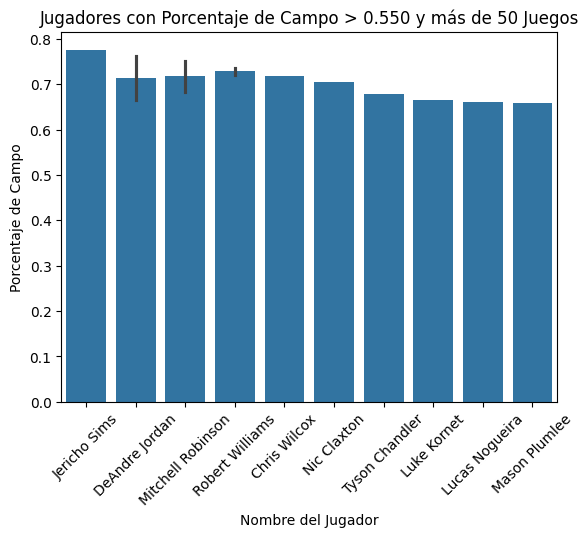

In [ ]:


client = pymongo.MongoClient("mongodb://mongo:27017/")
db = client["nba"]
collection = db["player_data"]

query1 = collection.find({
    "field_percent": { "$gt": "0.550" },
    "games": { "$gt": 50 }
}).sort("field_percent", -1).limit(15)

df1 = pd.DataFrame(list(query1))
# Asegúrate de que 'field_percent' sea numérico
df1['field_percent'] = pd.to_numeric(df1['field_percent'], errors='coerce')


display(df1)
sns.barplot(data=df1, x='player_name', y='field_percent')
plt.xticks(rotation=45)
plt.title('Jugadores con Porcentaje de Campo > 0.550 y más de 50 Juegos')
plt.ylabel('Porcentaje de Campo')
plt.xlabel('Nombre del Jugador')
plt.show()




2. Top 5 Jugadores por Asistencias en una Temporada Específica

Problema que Soluciona: Este análisis destaca a los jugadores con el mayor número de asistencias en la temporada 2010, crucial para entender quiénes son los mejores facilitadores en el juego.

_id  totalAssists
0     Rajon Rondo           794
1  Andre Iguodala           472
2    Aaron Brooks           434
3    Devin Harris           423
4    Jarrett Jack           413
5   José Calderón           404
6     Chris Duhon           378

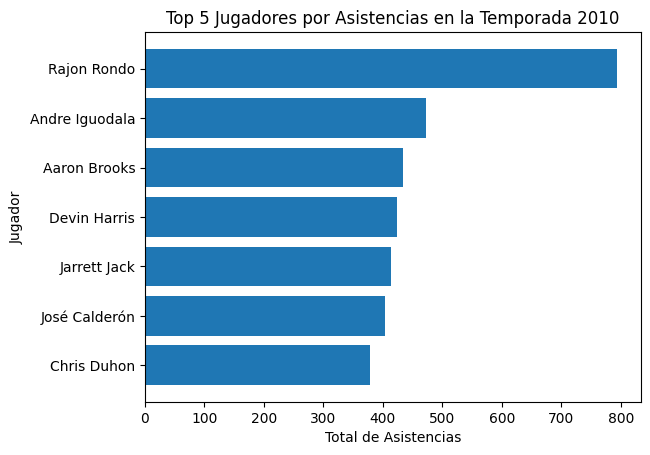

In [ ]:
query2 = collection.aggregate([
    { "$match": { "season": 2010 } },
    { "$group": { "_id": "$player_name", "totalAssists": { "$sum": "$AST" } } },
    { "$sort": { "totalAssists": -1 } },
    { "$limit": 7 }
])

df2 = pd.DataFrame(list(query2))

display(df2)
df2_sorted = df2.sort_values('totalAssists', ascending=True)
plt.barh(df2_sorted['_id'], df2_sorted['totalAssists'])
plt.xlabel('Total de Asistencias')
plt.ylabel('Jugador')
plt.title('Top 5 Jugadores por Asistencias en la Temporada 2010')
plt.show()



3. Mejor Jugador en Tiros de Tres Puntos por Temporada

Problema que Soluciona: Identifica al jugador con mejor promedio en tiros de tres puntos por temporada, proporcionando insights sobre los tiradores más eficientes año tras año.

In [34]:
from IPython.display import display
query3 = collection.aggregate([
    { "$unwind": "$season" },
    { "$group": { "_id": { "player": "$player_name", "season": "$season" }, "avgThreePoints": { "$avg": "$three_percent" } } },
    { "$sort": { "_id.season": 1, "avgThreePoints": -1 } },
    { "$group": { "_id": "$_id.season", "bestThreePointPlayer": { "$first": "$_id.player" } } },
    { "$sort": { "_id": 1 } }
])

df3 = pd.DataFrame(list(query3))

def plot_best_three_point_shooter(year):
    data = df3[df3['_id'] == year]
    if not data.empty:
        player = data.iloc[0]['bestThreePointPlayer']
        print(f"Mejor tirador de tres puntos en {year}: {player}")
    else:
        print("Datos no disponibles para este año.")

# Crear un widget deslizante para el año
year_slider = widgets.IntSlider(
    value=df3['_id'].min(),
    min=df3['_id'].min(),
    max=df3['_id'].max(),
    step=1,
    description='Año:',
    continuous_update=False
)

# Crear un widget interactivo
widgets.interact(plot_best_three_point_shooter, year=year_slider)


interactive(children=(IntSlider(value=2010, continuous_update=False, description='Año:', max=2023, min=2010), …

<function __main__.plot_best_three_point_shooter(year)>

4. Promedio de Puntos por Temporada para un Equipo Específico
Problema que Soluciona: Este query calcula el promedio de puntos por temporada del equipo "HOU", útil para analizar el rendimiento ofensivo del equipo a lo largo del tiempo.

_id   avgPoints
0   2010  399.761905
1   2011  434.250000
2   2012  340.736842
3   2013  434.400000
4   2014  490.500000
5   2015  426.100000
6   2016  485.388889
7   2017  525.444444
8   2018  383.875000
9   2019  406.130435
10  2020  403.904762
11  2021  261.100000
12  2022  473.526316
13  2023  504.500000

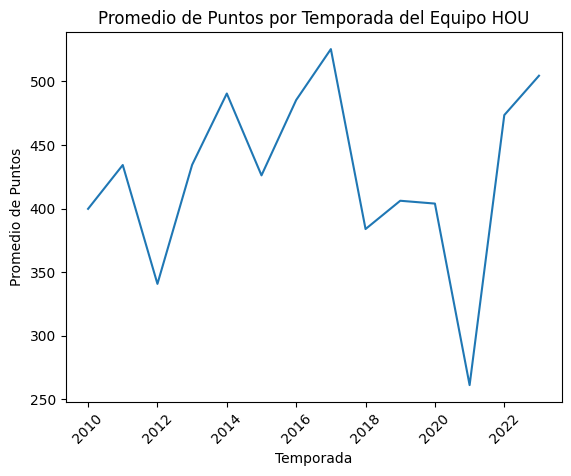

In [ ]:
query4 = collection.aggregate([
    { "$match": { "team": "HOU" } },
    { "$group": { "_id": "$season", "avgPoints": { "$avg": "$PTS" } } },
    { "$sort": { "_id": 1 } }
])

df4 = pd.DataFrame(list(query4))

display(df4)
plt.plot(df4['_id'], df4['avgPoints'])
plt.xticks(rotation=45)
plt.ylabel('Promedio de Puntos')
plt.xlabel('Temporada')
plt.title('Promedio de Puntos por Temporada del Equipo HOU')
plt.show()


## Cassandra


Pregunta: ¿Quién es el jugador con más puntos en la temporada 2020 para el equipo de Houston (HOU)?

In [ ]:
#SELECT player_name, MAX(PTS) FROM nba_stats WHERE team = 'HOU' AND season = 2020 ALLOW FILTERING;

session = cluster.connect('nba')
query = "SELECT player_name, MAX(PTS) FROM player_stats WHERE team = 'HOU' AND season = 2020 ALLOW FILTERING;"
rows = session.execute(query)
# Creando un DataFrame con los resultados
df = pd.DataFrame(list(rows))
print(df)



#Esta consulta muestra el jugador con el mayor número de puntos en una temporada específica para el equipo de Houston.

      player_name  system_max_pts
0  William Howard            2335


Esta solucion nos ayuda a saber el rendimiento de jugadores y saber quien le hace mejor al equipo.

Pregunta: ¿Cuál es el promedio de rebotes totales (TRB) por juego para el equipo de Boston (BOS) en la temporada 2021?

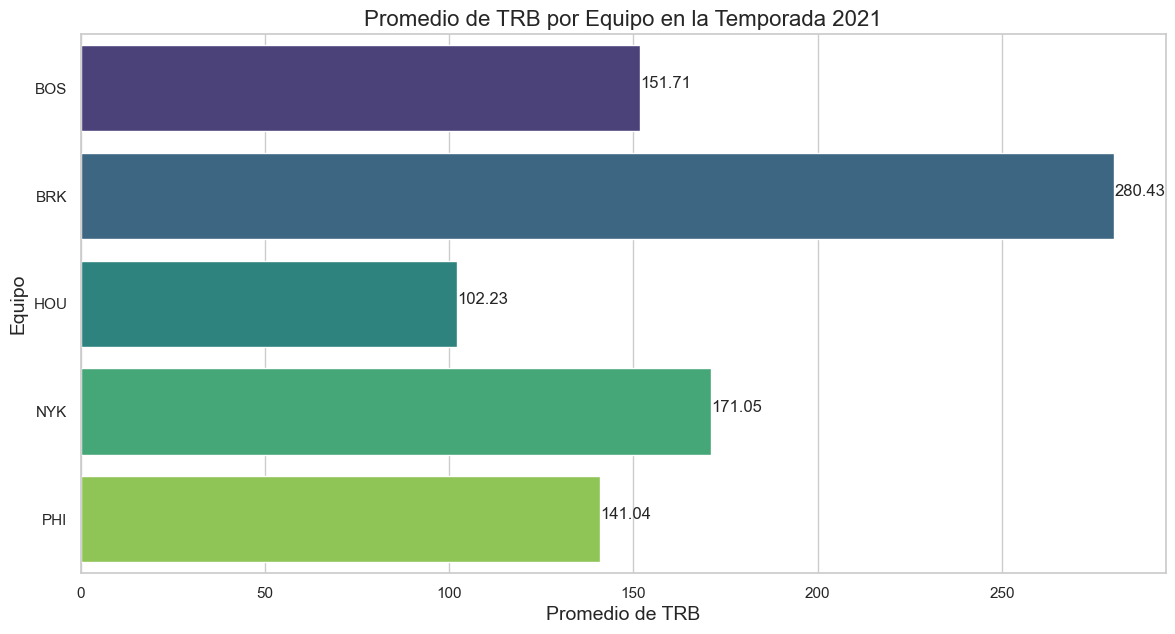

In [ ]:
#SELECT AVG(TRB) FROM nba_stats WHERE team = 'BOS' AND season = 2021 ALLOW FILTERING;

# Selecciona los rebotes totales y el equipo de la temporada 2021
query = """
SELECT team, TRB
FROM nba.player_stats
WHERE season = 2021
ALLOW FILTERING;
"""
rows = session.execute(query)
 
# Convierte los resultados a un DataFrame de pandas
df = pd.DataFrame(rows, columns=['team', 'TRB'])
 
# Calcula el promedio de TRB por equipo
average_trb_by_team = df.groupby('team')['TRB'].mean().reset_index()
 
# Renombra las columnas del DataFrame para claridad
average_trb_by_team.columns = ['Team', 'Average TRB']
 
# Establecer el tema para los gráficos
sns.set_theme(style="whitegrid")
 
# Crear un gráfico de barras
plt.figure(figsize=(14, 7))  # Puedes ajustar el tamaño según tus necesidades
barplot = sns.barplot(
    x='Average TRB',
    y='Team',
    data=average_trb_by_team,
    palette='viridis'
)
 
# Título y etiquetas
plt.title('Promedio de TRB por Equipo en la Temporada 2021', fontsize=16)
plt.xlabel('Promedio de TRB', fontsize=14)
plt.ylabel('Equipo', fontsize=14)
 
# Mostrar los valores en las barras
for index, value in enumerate(average_trb_by_team['Average TRB']):
    plt.text(value, index, f'{value:.2f}')  # Formatea a dos decimales si es necesario
 
# Mostrar la gráfica
plt.show()


#Esta consulta calcula el promedio de rebotes totales por juego para el equipo de Boston en una temporada específica.

Pregunta: ¿Cuántos juegos ganó el equipo de Toronto (TOR) en la temporada 2019?

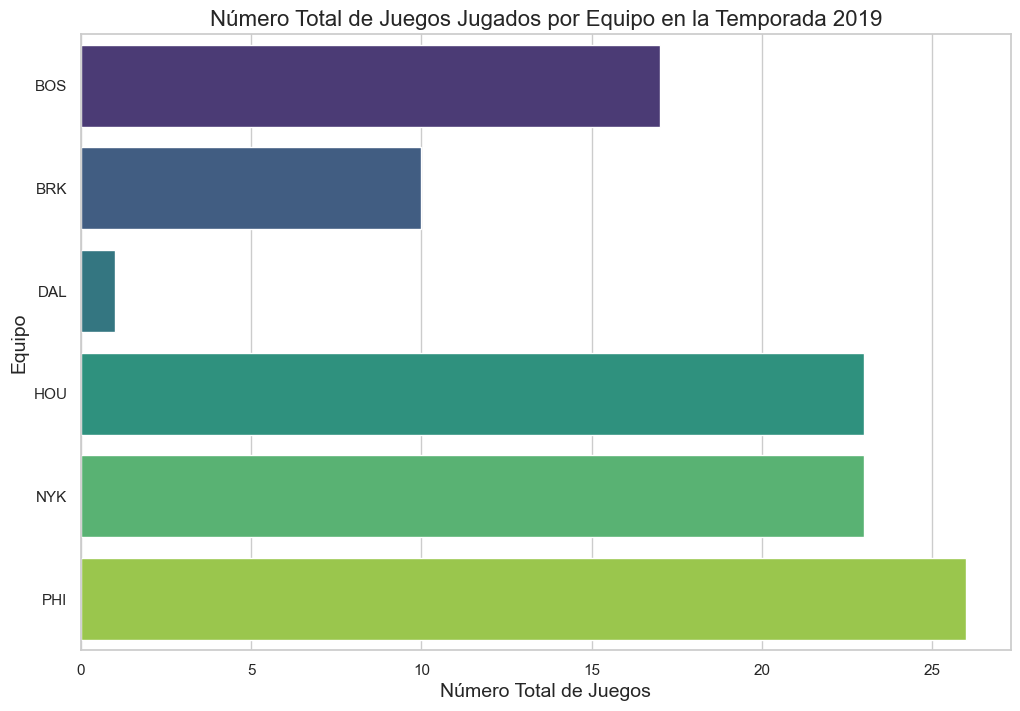

In [31]:
query = """
SELECT team, games
FROM nba.player_stats
WHERE season = 2019
ALLOW FILTERING;
"""
rows = session.execute(query)

# Creando un DataFrame con los resultados
df = pd.DataFrame(list(rows), columns=['team', 'games'])


games_per_team = df.groupby('team')['games'].count().reset_index()
games_per_team.columns = ['Team', 'Total Games']


# Configuración de Seaborn
sns.set_theme(style="whitegrid")

# Crear un gráfico de barras
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Total Games', y='Team', data=games_per_team, palette='viridis')

# Añadir título y etiquetas
plt.title('Número Total de Juegos Jugados por Equipo en la Temporada 2019', fontsize=16)
plt.xlabel('Número Total de Juegos', fontsize=14)
plt.ylabel('Equipo', fontsize=14)

# Mostrar gráfico
plt.show()

       player_name  season  ast  stl
0     James Harden    2015  565  154
1     Jrue Holiday    2013  625  123
2   T.J. McConnell    2017  534  134
3      Ben Simmons    2019  610  112
4     James Harden    2020  512  125
5      Ben Simmons    2018  661  140
6     Jrue Holiday    2011  531  120
7     James Harden    2017  907  121
8     James Harden    2018  630  126
9      Rajon Rondo    2011  760  153
10    James Harden    2016  612  139
11      Kyle Lowry    2014  586  121
12     Rajon Rondo    2010  794  189
13    James Harden    2019  586  158


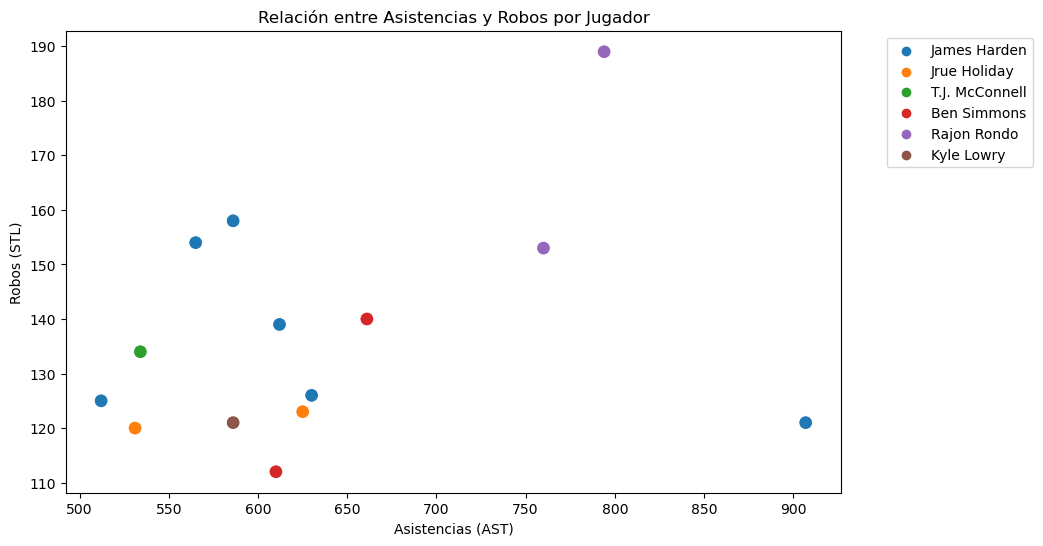

In [ ]:
query = """
SELECT player_name, season, AST, STL
FROM player_stats
WHERE AST > 500 AND STL > 100
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))
print(df)


if not df.empty and 'ast' in df.columns and 'stl' in df.columns:

    # Crear un gráfico de dispersión
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='ast', y='stl', hue='player_name', s=100)

    # Agregar títulos y etiquetas
    plt.title('Relación entre Asistencias y Robos por Jugador')
    plt.xlabel('Asistencias (AST)')
    plt.ylabel('Robos (STL)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Mostrar el gráfico
    plt.show()
else:
    print("El DataFrame está vacío o no contiene las columnas 'ast' y 'stl'.")


           player_name  season team  field_percent  field_attempts
7        Dwight Howard    2016  HOU          0.620             600
20   Amar'e Stoudemire    2011  NYK          0.502            1482
25        Clint Capela    2019  HOU          0.648             732
33      Thaddeus Young    2011  PHI          0.541             847
39        Kyrie Irving    2021  BRK          0.506            1086
..                 ...     ...  ...            ...             ...
359       Tyler Zeller    2015  BOS          0.549             619
361        Ben Simmons    2021  PHI          0.557             583
405          Ömer Aşık    2013  HOU          0.541             614
408  Kenyon Martin Jr.    2023  HOU          0.569             720
414     Andray Blatche    2013  BRK          0.512             676

[68 rows x 5 columns]


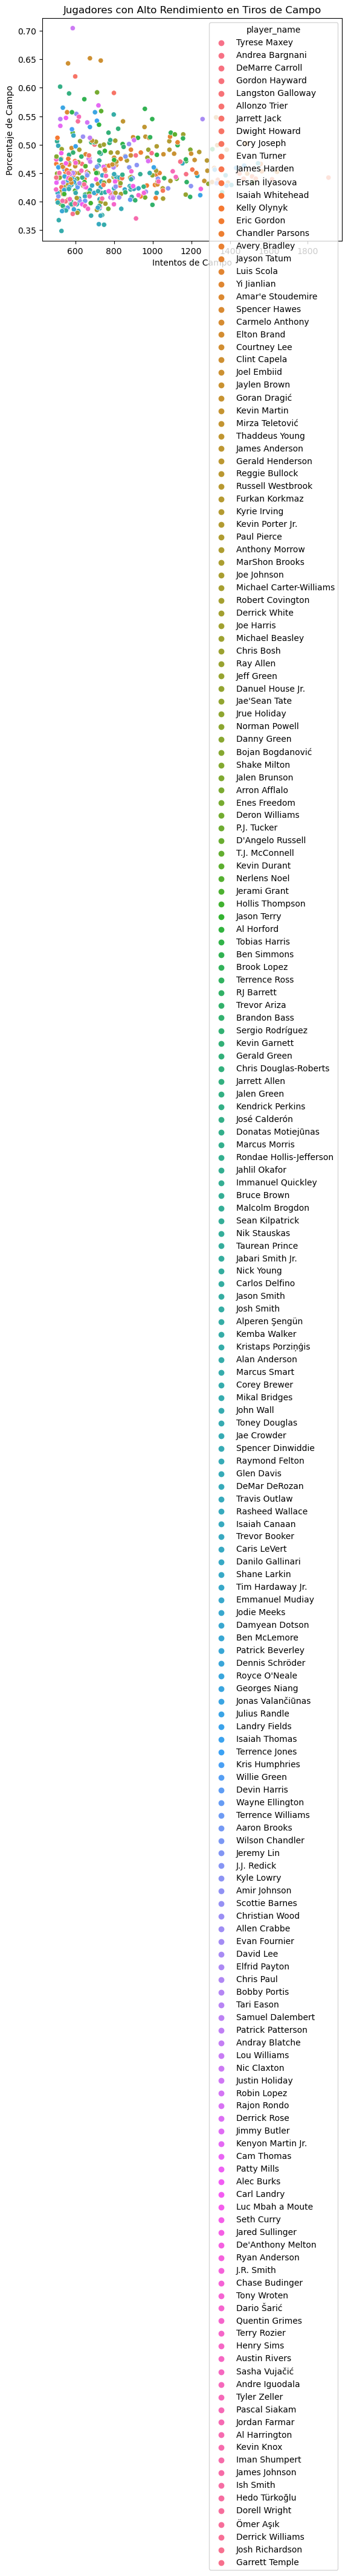

In [ ]:
query = """
SELECT player_name, season, team, field_percent, field_attempts
FROM player_stats
WHERE field_attempts > 500
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))

# Convertir field_percent a número y filtrar
df['field_percent'] = pd.to_numeric(df['field_percent'], errors='coerce')
df_filtered = df[df['field_percent'] >= 0.500]

print(df_filtered)

df['field_percent'] = pd.to_numeric(df['field_percent'], errors='coerce')

# Graficar
sns.scatterplot(data=df, x='field_attempts', y='field_percent', hue='player_name')
plt.title('Jugadores con Alto Rendimiento en Tiros de Campo')
plt.xlabel('Intentos de Campo')
plt.ylabel('Porcentaje de Campo')
plt.show()



          player_name  season team  drb  blk
0       Dwight Howard    2016  HOU  597  113
1        James Harden    2015  HOU  384   60
2        Jayson Tatum    2019  BOS  407   57
3   Amar'e Stoudemire    2011  NYK  438  150
4       Spencer Hawes    2013  PHI  417  113
..                ...     ...  ...  ...  ...
89        Aron Baynes    2018  BOS  304   51
90    Andrea Bargnani    2010  TOR  388  111
91      Kevin Garnett    2013  BOS  455   62
92          Ömer Aşık    2013  HOU  681   87
93       James Harden    2019  HOU  452   58

[94 rows x 5 columns]


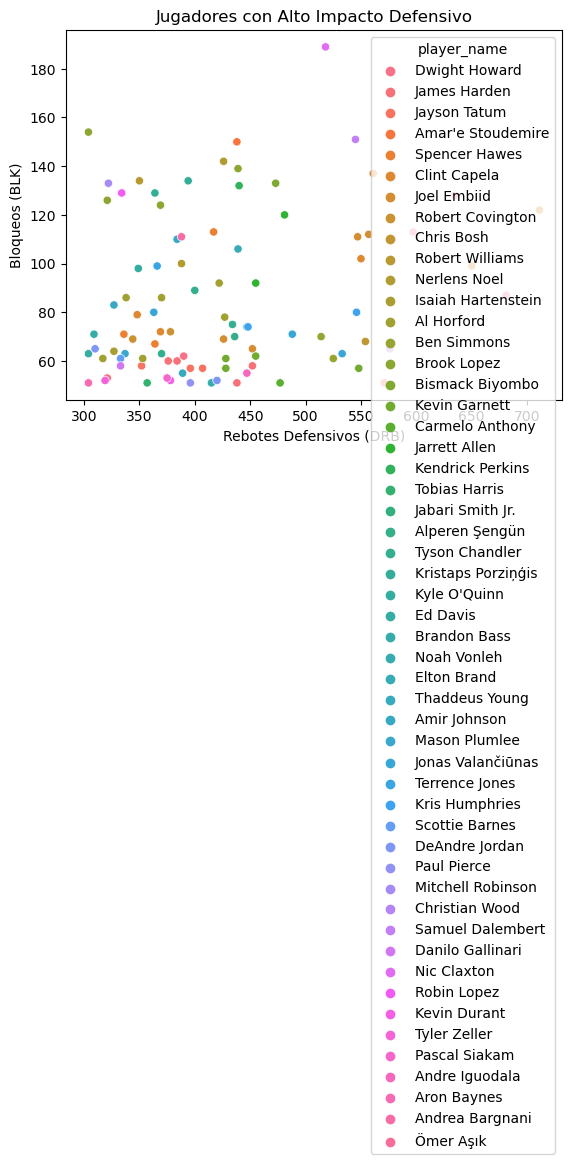

In [ ]:
query = """
SELECT player_name, season, team, DRB, BLK
FROM player_stats
WHERE DRB > 300 AND BLK > 50
ALLOW FILTERING;
"""
rows = session.execute(query)
df = pd.DataFrame(list(rows))
print(df)

sns.scatterplot(data=df, x='drb', y='blk', hue='player_name')
plt.title('Jugadores con Alto Impacto Defensivo')
plt.xlabel('Rebotes Defensivos (DRB)')
plt.ylabel('Bloqueos (BLK)')
plt.show()

## Neo4j

primero ejecutamos los siguientes codigos en mongo para que funcione de manera correcta el traspaso de informaciond e mongo a neo4j


In [32]:

client = MongoClient('mongodb://localhost:27017/')
#client = MongoClient('mongodb://mongo:27017/')
db = client['nba']  # Reemplaza con el nombre de tu base de datos
 
# Actualizar todos los documentos en la colección 'player_data'
db.player_data.update_many({}, {'$set': {'type': 'Player'}})
 
# Insertar varios documentos en la colección 'player_data'
db.player_data.insert_many([
    {'id': 10000, 'team_name': 'MEM', 'type': 'Team'},
    {'id': 10001, 'team_name': 'BOS', 'type': 'Team'},
    {'id': 10002, 'team_name': 'BRK', 'type': 'Team'},
    {'id': 10003, 'team_name': 'TOR', 'type': 'Team'},
    {'id': 10004, 'team_name': 'NJN', 'type': 'Team'},
    {'id': 10005, 'team_name': 'ATL', 'type': 'Team'},
    {'id': 10006, 'team_name': 'DAL', 'type': 'Team'},
    {'id': 10007, 'team_name': 'PHI', 'type': 'Team'},
    {'id': 10008, 'team_name': 'NYK', 'type': 'Team'},
    {'id': 10009, 'team_name': 'HOU', 'type': 'Team'}
])

In [33]:
from pymongo import MongoClient
from neo4j import GraphDatabase
#from py2neo import Graph

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['nba']
collection = db['player_data']

# Fetch data from MongoDB collection
mongo_data = collection.find()

# Connect to Neo4j
uri = "bolt://localhost:7687"
username = "neo4j"
password = "neo"
driver = GraphDatabase.driver(uri, auth=(username, password))

##################################
########## Create nodes ##########
##################################
players = []
teams = []

def create_player_node(tx, props):
    tx.run("CREATE (n:Player)"
    	   "SET n += $props", props=props)

def create_team_node(tx, props):
    tx.run("CREATE (n:Team)"
    	   "SET n += $props", props=props)

#with driver.session() as session:
	#player_0 = list(mongo_data)[1]
	#player_0.pop('_id') # Removes object id
	#player_0.pop('id')
	#session.execute_write(create_player_node, player_0)

# Add a node for each json in the db
with driver.session() as session:
	for doc in mongo_data:
		# Player nodes
		if doc['type'] == 'Player':
			# Removes id and object id
			doc.pop('_id')
			doc.pop('id')
			players.append(doc)
			session.execute_write(create_player_node, doc)
		# Team nodes
		elif doc['type'] == 'Team':
			# Removes id and object id
			doc.pop('_id')
			doc.pop('id')
			# Removes player list
			#doc.pop('players')
			teams.append(doc)
			session.execute_write(create_team_node, doc)


##################################
########## Create edges ##########
##################################
def create_edges(tx):
	tx.run("""
		   MATCH (p:Player),(t:Team)
		   WHERE p.team = t.team_name
	  	   CREATE (p)-[:PART_OF]->(t);
	  	   """)

# Add an edge going from each player to his team
with driver.session() as session:
	session.execute_write(create_edges)


'''
@staticmethod
def _create_and_return_greeting(tx, message):
    result = tx.run("CREATE (a:Greeting) "
                    "SET a.message = $message "
                    "RETURN a.message + ', from node ' + id(a)", message=message)
    return result.single()[0]

with driver.session() as session:
    greeting = session.execute_write(_create_and_return_greeting, "Hello world")
    print(greeting)

driver.close()
'''


'''
# Set type por all players in the database
db.player_data.updateMany({}, {$set: {'type': "Player"}})

# Find all teams
db.player_data.aggregate([ { $group: {_id: "$team"} }  ])

# Find all seasons
db.player_data.aggregate([ { $group: {_id: "$team"} }  ])

# Find all teams from each team


# Insert teams
db.player_data.insertMany(
[
{ 'id': 10000, 'team_name': 'MEM', 'type': 'Team' },
{ 'id': 10001, 'team_name': 'BOS', 'type': 'Team' },
{ 'id': 10002, 'team_name': 'BRK', 'type': 'Team' },
{ 'id': 10003, 'team_name': 'TOR', 'type': 'Team' },
{ 'id': 10004, 'team_name': 'NJN', 'type': 'Team' },
{ 'id': 10005, 'team_name': 'ATL', 'type': 'Team' },
{ 'id': 10006, 'team_name': 'DAL', 'type': 'Team' },
{ 'id': 10007, 'team_name': 'PHI', 'type': 'Team' },
{ 'id': 10008, 'team_name': 'NYK', 'type': 'Team' },
{ 'id': 10009, 'team_name': 'HOU', 'type': 'Team' }
])



{
    id: 7562,
    type: 'Team',
    team_name: 'HOU',
    players: [
	  'Tarik Black', 'Daishen Nix', 'Chris Chiozza', 'Kenneth Faried', 'Carmelo Anthony', 'Kevin Martin',
	  'Marquese Chriss', 'Lou Williams', 'Eric Gordon', 'Dwight Howard', 'Jeff Green', 'Frank Kaminsky',
	  'Clint Capela', 'Pops Mensah-Bonsu', 'Darius Days', 'Alexey Shved', 'James Harden', 'Troy Daniels',
	  'Nick Johnson', 'Cameron Reynolds', 'William Howard', 'Rodions Kurucs', 'Tari Eason', 'Josh Christopher',
	  'Marcus Camby', 'Thomas Robinson', 'Chris Clemons', 'Pablo Prigioni', 'Kyle Wiltjer', 'Cameron Oliver',
	  'Kyle Lowry', 'Danuel House Jr.', 'Isaiah Hartenstein', 'Courtney Fortson', 'Marcus Thornton', 
	  'Khyri Thomas', 'Aaron Brooks', 'Goran Dragić', 'Sam Dekker', 'Luis Scola', 'Kenyon Martin Jr.',
	  'Austin Rivers', 'Kevin Porter Jr.', 'Courtney Lee', 'Yao Ming', 'Toney Douglas', 'Tyler Ennis',
	  'Thabo Sefolosha', 'Ray Spalding', 'Demetrius Jackson', 'D.J. Wilson', 'DeMarre Carroll', 'Samuel Dalembert',
	  'Michael Beasley', 'Sterling Brown', 'Jae'Sean Tate', 'Aaron Jackson', 'Russell Westbrook',
	  'Jared Jeffries', 'Cole Aldrich', 'Tyson Chandler', 'Isaiah Canaan', 'Jordan Hamilton', 'Terrence Williams',
	  'Jalen Green', 'Bruno Fernando', 'Jabari Smith Jr.', 'Troy Williams', 'John Wall', 'Ish Smith', 'Ty Lawson', 
	  'Michael Carter-Williams', 'Markel Brown', 'Zhou Qi', 'Carl Landry', 'Brandon Knight', 'Brodric Thomas',
	  'David Andersen', 'Mike Harris', 'Brian Cook', 'Jeremy Lin', 'Francisco García', 'Terrence Jones',
	  'Corey Brewer', 'Ömer Aşık', 'Josh Powell', 'Avery Bradley', 'David Nwaba', 'Will Conroy', 
	  'Jermaine Taylor', 'Ben McLemore', 'Joe Johnson', 'Brad Miller', 'Hasheem Thabeet', 'Montrezl Harrell',
	  'Carlos Delfino', 'Tim Quarterman', 'Iman Shumpert', 'Chuck Hayes', 'Chase Budinger', 'DeMarcus Cousins',
	  'Briante Weber', 'Ronnie Brewer', 'Gerald Green', 'Trevelin Queen', 'Gary Clark', 'Kostas Papanikolaou',
	  'Tim Ohlbrecht', 'Anthony Lamb', 'Michael Frazier', 'Tracy McGrady', 'Jeff Adrien', 'Marcus Morris',
	  'Shane Battier', 'Ryan Anderson', 'Christian Wood', 'Armoni Brooks', 'Earl Boykins', 'R.J. Hunter',
	  'K.J. McDaniels', 'Isaiah Taylor', 'Garrett Temple', 'Jordan Hill', 'Donatas Motiejūnas', 'P.J. Tucker',
	  'Mason Jones', 'Chinanu Onuaku', 'Omri Casspi', 'TyTy Washington Jr.', 'Jonny Flynn', 'Jason Terry',
	  'Justin Patton', 'Robert Covington', 'D.J. Augustin', 'Boban Marjanović', 'Chandler Parsons',
	  'Daniel Theis', 'Garrison Mathews', 'Daequan Cook', 'Dennis Schröder', 'Vince Edwards', 'Trevor Hudgins',
	  'Joey Dorsey', 'Greg Smith', 'Patrick Patterson', 'James Ennis III', 'Hilton Armstrong', 'Kelly Olynyk',
	  'Bruno Caboclo', 'Chris Paul', 'Victor Oladipo', 'Patrick Beverley', 'Nenê', 'Scott Machado', 'Alperen Şengün', 
	  'Luc Mbah a Moute', 'Usman Garuba', 'Trevor Ariza', 'Bobby Brown', 'DaQuan Jeffries', 'James Anderson',
	  'Josh Smith', 'James Nunnally'
    ]
    
    player_name: 'Will Conroy',
    games: 5,
    games_started: 0,
    minutes_played: 36,
    field_goals: 3,
    field_attempts: 10,
    field_percent: '0.300',
    three_fg: 0,
    three_attempts: 3,
    three_percent: '0.000',
    two_fg: 3,
    two_attempts: 7,
    two_percent: '0.429',
    effect_fg_percent: '0.300',
    ft: 0,
    fta: 2,
    ft_percent: '0.000',
    ORB: 0,
    DRB: 3,
    TRB: 3,
    AST: 7,
    STL: 0,
    BLK: 0,
    TOV: 4,
    PF: 5,
    PTS: 6,
    team: 'HOU',
    season: 2010,
    type: 'Person
}


# label: age, 
# nodes: players, seasons, teams


db.nba.aggregate([
	{ $match: {<conditions>} },
	{ $project: {team: 1} },
	{ $group: {_id: "$team"}, [var]:{<operation>} },
	{ $sort: {_id: "$<field>"}, [var]:{<operation>} },
	{ $out: "<new_collection>" }
])
'''

'''
{ _id: 'HOU', unique: 'Andrew Goudelock' },
  { _id: 'HOU', unique: 'Tarik Black' },
  { _id: 'HOU', unique: 'Daishen Nix' },
  { _id: 'HOU', unique: 'Chris Chiozza' },
  { _id: 'HOU', unique: 'Kenneth Faried' },
  { _id: 'HOU', unique: 'Carmelo Anthony' },
  { _id: 'HOU', unique: 'Kevin Martin' },
  { _id: 'HOU', unique: 'Marquese Chriss' },
  { _id: 'HOU', unique: 'Lou Williams' },
  { _id: 'HOU', unique: 'Eric Gordon' },
  { _id: 'HOU', unique: 'Dwight Howard' },
  { _id: 'HOU', unique: 'Jeff Green' },
  { _id: 'HOU', unique: 'Frank Kaminsky' },
  { _id: 'HOU', unique: 'Clint Capela' },
  { _id: 'HOU', unique: 'Pops Mensah-Bonsu' },
  { _id: 'HOU', unique: 'Darius Days' },
  { _id: 'HOU', unique: 'Alexey Shved' },
  { _id: 'HOU', unique: 'James Harden' },
  { _id: 'HOU', unique: 'Troy Daniels' },
  { _id: 'HOU', unique: 'Nick Johnson' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Cameron Reynolds' },
  { _id: 'HOU', unique: 'William Howard' },
  { _id: 'HOU', unique: 'Rodions Kurucs' },
  { _id: 'HOU', unique: 'Tari Eason' },
  { _id: 'HOU', unique: 'Josh Christopher' },
  { _id: 'HOU', unique: 'Marcus Camby' },
  { _id: 'HOU', unique: 'Thomas Robinson' },
  { _id: 'HOU', unique: 'Chris Clemons' },
  { _id: 'HOU', unique: 'Pablo Prigioni' },
  { _id: 'HOU', unique: 'Kyle Wiltjer' },
  { _id: 'HOU', unique: 'Cameron Oliver' },
  { _id: 'HOU', unique: 'Kyle Lowry' },
  { _id: 'HOU', unique: 'Danuel House Jr.' },
  { _id: 'HOU', unique: 'Isaiah Hartenstein' },
  { _id: 'HOU', unique: 'Courtney Fortson' },
  { _id: 'HOU', unique: 'Marcus Thornton' },
  { _id: 'HOU', unique: 'Khyri Thomas' },
  { _id: 'HOU', unique: 'Brandan Wright' },
  { _id: 'HOU', unique: 'Aaron Brooks' },
  { _id: 'HOU', unique: 'Goran Dragić' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Sam Dekker' },
  { _id: 'HOU', unique: 'Luis Scola' },
  { _id: 'HOU', unique: 'Kenyon Martin Jr.' },
  { _id: 'HOU', unique: 'Austin Rivers' },
  { _id: 'HOU', unique: 'Kevin Porter Jr.' },
  { _id: 'HOU', unique: 'Courtney Lee' },
  { _id: 'HOU', unique: 'Yao Ming' },
  { _id: 'HOU', unique: 'Toney Douglas' },
  { _id: 'HOU', unique: 'Tyler Ennis' },
  { _id: 'HOU', unique: 'Thabo Sefolosha' },
  { _id: 'HOU', unique: 'Ray Spalding' },
  { _id: 'HOU', unique: 'Demetrius Jackson' },
  { _id: 'HOU', unique: 'D.J. Wilson' },
  { _id: 'HOU', unique: 'DeMarre Carroll' },
  { _id: 'HOU', unique: 'Samuel Dalembert' },
  { _id: 'HOU', unique: 'Michael Beasley' },
  { _id: 'HOU', unique: 'Sterling Brown' },
  { _id: 'HOU', unique: "Jae'Sean Tate" },
  { _id: 'HOU', unique: 'Aaron Jackson' },
  { _id: 'HOU', unique: 'Russell Westbrook' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Jared Jeffries' },
  { _id: 'HOU', unique: 'Cole Aldrich' },
  { _id: 'HOU', unique: 'Tyson Chandler' },
  { _id: 'HOU', unique: 'Isaiah Canaan' },
  { _id: 'HOU', unique: 'Jordan Hamilton' },
  { _id: 'HOU', unique: 'Terrence Williams' },
  { _id: 'HOU', unique: 'Jalen Green' },
  { _id: 'HOU', unique: 'Bruno Fernando' },
  { _id: 'HOU', unique: 'Jabari Smith Jr.' },
  { _id: 'HOU', unique: 'Troy Williams' },
  { _id: 'HOU', unique: 'John Wall' },
  { _id: 'HOU', unique: 'Ish Smith' },
  { _id: 'HOU', unique: 'Ty Lawson' },
  { _id: 'HOU', unique: 'Michael Carter-Williams' },
  { _id: 'HOU', unique: 'Markel Brown' },
  { _id: 'HOU', unique: 'Zhou Qi' },
  { _id: 'HOU', unique: 'Carl Landry' },
  { _id: 'HOU', unique: 'Brandon Knight' },
  { _id: 'HOU', unique: 'Brodric Thomas' },
  { _id: 'HOU', unique: 'David Andersen' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Mike Harris' },
  { _id: 'HOU', unique: 'Brian Cook' },
  { _id: 'HOU', unique: 'Jeremy Lin' },
  { _id: 'HOU', unique: 'Francisco García' },
  { _id: 'HOU', unique: 'Terrence Jones' },
  { _id: 'HOU', unique: 'Corey Brewer' },
  { _id: 'HOU', unique: 'Ömer Aşık' },
  { _id: 'HOU', unique: 'Josh Powell' },
  { _id: 'HOU', unique: 'Avery Bradley' },
  { _id: 'HOU', unique: 'David Nwaba' },
  { _id: 'HOU', unique: 'Will Conroy' },
  { _id: 'HOU', unique: 'Jermaine Taylor' },
  { _id: 'HOU', unique: 'Ben McLemore' },
  { _id: 'HOU', unique: 'Joe Johnson' },
  { _id: 'HOU', unique: 'Brad Miller' },
  { _id: 'HOU', unique: 'Hasheem Thabeet' },
  { _id: 'HOU', unique: 'Montrezl Harrell' },
  { _id: 'HOU', unique: 'Carlos Delfino' },
  { _id: 'HOU', unique: 'Tim Quarterman' },
  { _id: 'HOU', unique: 'Iman Shumpert' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Chuck Hayes' },
  { _id: 'HOU', unique: 'Chase Budinger' },
  { _id: 'HOU', unique: 'DeMarcus Cousins' },
  { _id: 'HOU', unique: 'Briante Weber' },
  { _id: 'HOU', unique: 'Ronnie Brewer' },
  { _id: 'HOU', unique: 'Gerald Green' },
  { _id: 'HOU', unique: 'Trevelin Queen' },
  { _id: 'HOU', unique: 'Gary Clark' },
  { _id: 'HOU', unique: 'Kostas Papanikolaou' },
  { _id: 'HOU', unique: 'Tim Ohlbrecht' },
  { _id: 'HOU', unique: 'Anthony Lamb' },
  { _id: 'HOU', unique: 'Michael Frazier' },
  { _id: 'HOU', unique: 'Tracy McGrady' },
  { _id: 'HOU', unique: 'Jeff Adrien' },
  { _id: 'HOU', unique: 'Marcus Morris' },
  { _id: 'HOU', unique: 'Shane Battier' },
  { _id: 'HOU', unique: 'Ryan Anderson' },
  { _id: 'HOU', unique: 'Christian Wood' },
  { _id: 'HOU', unique: 'Armoni Brooks' },
  { _id: 'HOU', unique: 'Earl Boykins' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'R.J. Hunter' },
  { _id: 'HOU', unique: 'K.J. McDaniels' },
  { _id: 'HOU', unique: 'Isaiah Taylor' },
  { _id: 'HOU', unique: 'Garrett Temple' },
  { _id: 'HOU', unique: 'Jordan Hill' },
  { _id: 'HOU', unique: 'Donatas Motiejūnas' },
  { _id: 'HOU', unique: 'P.J. Tucker' },
  { _id: 'HOU', unique: 'Mason Jones' },
  { _id: 'HOU', unique: 'Chinanu Onuaku' },
  { _id: 'HOU', unique: 'Omri Casspi' },
  { _id: 'HOU', unique: 'TyTy Washington Jr.' },
  { _id: 'HOU', unique: 'Jonny Flynn' },
  { _id: 'HOU', unique: 'Jason Terry' },
  { _id: 'HOU', unique: 'Justin Patton' },
  { _id: 'HOU', unique: 'Robert Covington' },
  { _id: 'HOU', unique: 'D.J. Augustin' },
  { _id: 'HOU', unique: 'Boban Marjanović' },
  { _id: 'HOU', unique: 'Chandler Parsons' },
  { _id: 'HOU', unique: 'Daniel Theis' },
  { _id: 'HOU', unique: 'Garrison Mathews' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Daequan Cook' },
  { _id: 'HOU', unique: 'Dennis Schröder' },
  { _id: 'HOU', unique: 'Vince Edwards' },
  { _id: 'HOU', unique: 'Trevor Hudgins' },
  { _id: 'HOU', unique: 'Joey Dorsey' },
  { _id: 'HOU', unique: 'Greg Smith' },
  { _id: 'HOU', unique: 'Patrick Patterson' },
  { _id: 'HOU', unique: 'James Ennis III' },
  { _id: 'HOU', unique: 'Hilton Armstrong' },
  { _id: 'HOU', unique: 'Kelly Olynyk' },
  { _id: 'HOU', unique: 'Bruno Caboclo' },
  { _id: 'HOU', unique: 'Chris Paul' },
  { _id: 'HOU', unique: 'Victor Oladipo' },
  { _id: 'HOU', unique: 'Patrick Beverley' },
  { _id: 'HOU', unique: 'Nenê' },
  { _id: 'HOU', unique: 'Scott Machado' },
  { _id: 'HOU', unique: 'Alperen Şengün' },
  { _id: 'HOU', unique: 'Luc Mbah a Moute' },
  { _id: 'HOU', unique: 'Usman Garuba' },
  { _id: 'HOU', unique: 'Trevor Ariza' }
]
Type "it" for more
nba> it
[
  { _id: 'HOU', unique: 'Bobby Brown' },
  { _id: 'HOU', unique: 'DaQuan Jeffries' },
  { _id: 'HOU', unique: 'James Anderson' },
  { _id: 'HOU', unique: 'Josh Smith' },
  { _id: 'HOU', unique: 'James Nunnally' },
  { _id: 'BRK', unique: 'Chris Chiozza' },
  { _id: 'BRK', unique: 'Gerald Wallace' },
  { _id: 'BRK', unique: 'Thaddeus Young' },
  { _id: 'BRK', unique: 'Kevin Durant' },
  { _id: 'BRK', unique: 'Jeff Green' },
  { _id: 'BRK', unique: 'Timothé Luwawu-Cabarrot' },
  { _id: 'BRK', unique: 'Quincy Acy' },
  { _id: 'BRK', unique: 'James Harden' },
  { _id: 'BRK', unique: 'Andrew Nicholson' },
  { _id: 'BRK', unique: 'MarShon Brooks' },
  { _id: 'BRK', unique: 'Marquis Teague' },
  { _id: 'BRK', unique: 'Rodions Kurucs' },
  { _id: 'BRK', unique: "D'Angelo Russell" },
  { _id: 'BRK', unique: 'Ben Simmons' },
  { _id: 'BRK', unique: 'Thomas Robinson' }
]
Type "it" for more
nba> it
[
  { _id: 'BRK', unique: 'Joe Harris' },
  { _id: 'BRK', unique: 'Tyler Johnson' },
  { _id: 'BRK', unique: 'Marcus Thornton' },
  { _id: 'BRK', unique: 'Seth Curry' },
  { _id: 'BRK', unique: 'Andray Blatche' },
  { _id: 'BRK', unique: 'Damion James' },
  { _id: 'BRK', unique: 'Jarrett Jack' },
  { _id: 'BRK', unique: 'Luis Scola' },
  { _id: 'BRK', unique: 'DeAndre Jordan' },
  { _id: 'BRK', unique: 'Bruce Brown' },
  { _id: 'BRK', unique: 'Edmond Sumner' },
  { _id: 'BRK', unique: 'DeMarre Carroll' },
  { _id: 'BRK', unique: 'Kris Humphries' },
  { _id: 'BRK', unique: 'Tyshawn Taylor' },
  { _id: 'BRK', unique: 'Markieff Morris' },
  { _id: 'BRK', unique: 'Henry Ellenson' },
  { _id: 'BRK', unique: 'Bojan Bogdanović' },
  { _id: 'BRK', unique: 'Allen Crabbe' },
  { _id: 'BRK', unique: 'Jamal Crawford' },
  { _id: 'BRK', unique: 'Spencer Dinwiddie' }
]
Type "it" for more
nba> it
[
  { _id: 'BRK', unique: 'Alan Anderson' },
  { _id: 'BRK', unique: 'James Johnson' },
  { _id: 'BRK', unique: 'Donta Hall' },
  { _id: 'BRK', unique: 'Markel Brown' },
  { _id: 'BRK', unique: 'Jared Dudley' },
  { _id: 'BRK', unique: 'RaiQuan Gray' },
  { _id: 'BRK', unique: 'Jason Collins' },
  { _id: 'BRK', unique: 'Sean Kilpatrick' },
  { _id: 'BRK', unique: 'Andrea Bargnani' },
  { _id: 'BRK', unique: 'Jeremy Lin' },
  { _id: 'BRK', unique: 'David Nwaba' },
  { _id: 'BRK', unique: 'Mikal Bridges' },
  { _id: 'BRK', unique: 'Džanan Musa' },
  { _id: 'BRK', unique: 'Kessler Edwards' },
  { _id: 'BRK', unique: 'Kyrie Irving' },
  { _id: 'BRK', unique: 'Moses Brown' },
  { _id: 'BRK', unique: 'Joe Johnson' },
  { _id: 'BRK', unique: 'Shane Larkin' },
  { _id: 'BRK', unique: 'Landry Shamet' },
  { _id: 'BRK', unique: 'Ed Davis' }
]
Type "it" for more
nba> it
[
  { _id: 'BRK', unique: 'Jarrett Allen' },
  { _id: 'BRK', unique: 'Yogi Ferrell' },
  { _id: 'BRK', unique: 'David Duke Jr.' },
  { _id: 'BRK', unique: 'Anthony Bennett' },
  { _id: 'BRK', unique: 'Iman Shumpert' },
  { _id: 'BRK', unique: 'Keith Bogans' },
  { _id: 'BRK', unique: 'Cameron Johnson' },
  { _id: 'BRK', unique: 'Nerlens Noel' },
  { _id: 'BRK', unique: 'Sergey Karasev' },
  { _id: 'BRK', unique: 'Wilson Chandler' },
  { _id: 'BRK', unique: 'Yuta Watanabe' },
  { _id: 'BRK', unique: 'Shaun Livingston' },
  { _id: 'BRK', unique: 'Brook Lopez' },
  { _id: 'BRK', unique: 'Nic Claxton' },
  { _id: 'BRK', unique: 'Rondae Hollis-Jefferson' },
  { _id: 'BRK', unique: 'Theo Pinson' },
  { _id: 'BRK', unique: 'Reggie Evans' },
  { _id: 'BRK', unique: 'Justin Hamilton' },
  { _id: 'BRK', unique: 'Cam Thomas' },
  { _id: 'BRK', unique: "Day'Ron Sharpe" }
]
Type "it" for more
nba> it
[
  { _id: 'BRK', unique: 'Paul Pierce' },
  { _id: 'BRK', unique: 'K.J. McDaniels' },
  { _id: 'BRK', unique: 'Garrett Temple' },
  { _id: 'BRK', unique: 'Kevin Garnett' },
  { _id: 'BRK', unique: 'Trevor Booker' },
  { _id: 'BRK', unique: 'Lance Thomas' },
  { _id: 'BRK', unique: 'Alondes Williams' },
  { _id: 'BRK', unique: 'C.J. Watson' },
  { _id: 'BRK', unique: 'Taurean Prince' },
  { _id: 'BRK', unique: 'Tornike Shengelia' },
  { _id: 'BRK', unique: 'Jason Terry' },
  { _id: 'BRK', unique: 'Jorge Gutiérrez' },
  { _id: 'BRK', unique: 'Kris Joseph' },
  { _id: 'BRK', unique: 'Randy Foye' },
  { _id: 'BRK', unique: 'Patty Mills' },
  { _id: 'BRK', unique: 'Andrei Kirilenko' },
  { _id: 'BRK', unique: 'Isaiah Whitehead' },
  { _id: 'BRK', unique: 'T.J. Warren' },
  { _id: 'BRK', unique: 'Wayne Ellington' },
  { _id: 'BRK', unique: 'Dru Smith' }
]
Type "it" for more
nba> it
[
  { _id: 'BRK', unique: 'Cory Jefferson' },
  { _id: 'BRK', unique: 'Dorian Finney-Smith' },
  { _id: 'BRK', unique: 'Tyler Zeller' },
  { _id: 'BRK', unique: 'Deron Williams' },
  { _id: 'BRK', unique: "Royce O'Neale" },
  { _id: 'BRK', unique: 'Josh Childress' },
  { _id: 'BRK', unique: 'Mirza Teletović' },
  { _id: 'BRK', unique: 'Henry Sims' },
  { _id: 'BRK', unique: 'Nik Stauskas' },
  { _id: 'BRK', unique: 'Mason Plumlee' },
  { _id: 'BRK', unique: 'Willie Reed' },
  { _id: 'BRK', unique: 'Caris LeVert' },
  { _id: 'BRK', unique: 'Archie Goodwin' },
  { _id: 'BRK', unique: 'Donald Sloan' },
  { _id: 'BRK', unique: 'Chris McCullough' },
  { _id: 'BRK', unique: 'Greivis Vásquez' },
  { _id: 'BRK', unique: 'Jeremiah Martin' },
  { _id: 'BRK', unique: 'Jerry Stackhouse' },
  { _id: 'BRK', unique: 'Justin Anderson' },
  { _id: 'DAL', unique: 'Ray Spalding' }
]
Type "it" for more
nba> it
[
  { _id: 'TOR', unique: 'Patrick Patterson' },
  { _id: 'TOR', unique: 'Hedo Türkoğlu' },
  { _id: 'TOR', unique: 'DeMarre Carroll' },
  { _id: 'TOR', unique: 'DeMar DeRozan' },
  { _id: 'TOR', unique: 'Linas Kleiza' },
  { _id: 'TOR', unique: 'Bismack Biyombo' },
  { _id: 'TOR', unique: 'Alan Anderson' },
  { _id: 'TOR', unique: 'Chris Bosh' },
  { _id: 'TOR', unique: 'James Johnson' },
  { _id: 'TOR', unique: 'Cory Joseph' },
  { _id: 'TOR', unique: 'Delon Wright' },
  { _id: 'TOR', unique: 'Jason Thompson' },
  { _id: 'TOR', unique: 'Jarrett Jack' },
  { _id: 'TOR', unique: 'Pascal Siakam' },
  { _id: 'TOR', unique: 'Luis Scola' },
  { _id: 'TOR', unique: 'Lucas Nogueira' },
  { _id: 'TOR', unique: 'Anthony Bennett' },
  { _id: 'TOR', unique: 'José Calderón' },
  { _id: 'TOR', unique: 'Amir Johnson' },
  { _id: 'TOR', unique: 'Terrence Ross' }
]
Type "it" for more
nba> it
[
  { _id: 'TOR', unique: 'Ed Davis' },
  { _id: 'TOR', unique: 'Norman Powell' },
  { _id: 'TOR', unique: 'Scottie Barnes' },
  { _id: 'TOR', unique: 'Leandro Barbosa' },
  { _id: 'TOR', unique: 'Andrea Bargnani' },
  { _id: 'TOR', unique: 'Kyle Lowry' },
  { _id: 'TOR', unique: 'Jonas Valančiūnas' },
  { _id: 'IND', unique: 'Ben Moore' },
  { _id: 'NJN', unique: 'Mario West' },
  { _id: 'NJN', unique: 'Kris Humphries' },
  { _id: 'NJN', unique: 'Larry Owens' },
  { _id: 'NJN', unique: 'Joe Smith' },
  { _id: 'NJN', unique: 'Jordan Farmar' },
  { _id: 'NJN', unique: 'Jordan Williams' },
  { _id: 'NJN', unique: 'Gerald Wallace' },
  { _id: 'NJN', unique: 'Bobby Simmons' },
  { _id: 'NJN', unique: 'Stephen Graham' },
  { _id: 'NJN', unique: 'Eduardo Nájera' },
  { _id: 'NJN', unique: 'Devin Harris' },
  { _id: 'NJN', unique: 'Travis Outlaw' }
]
Type "it" for more
nba> it
[
  { _id: 'NJN', unique: 'Anthony Morrow' },
  { _id: 'NJN', unique: 'Terrence Williams' },
  { _id: 'NJN', unique: 'Keyon Dooling' },
  { _id: 'NJN', unique: 'MarShon Brooks' },
  { _id: 'NJN', unique: 'Shawne Williams' },
  { _id: 'NJN', unique: 'Trenton Hassell' },
  { _id: 'NJN', unique: 'Mehmet Okur' },
  { _id: 'NJN', unique: 'Armon Johnson' },
  { _id: 'NJN', unique: 'Gerald Green' },
  { _id: 'NJN', unique: 'Keith Bogans' },
  { _id: 'NJN', unique: 'Dennis Horner' },
  { _id: 'NJN', unique: 'Deron Williams' },
  { _id: 'NJN', unique: 'Chris Douglas-Roberts' },
  { _id: 'NJN', unique: 'Sasha Vujačić' },
  { _id: 'NJN', unique: 'Johan Petro' },
  { _id: 'NJN', unique: 'Ben Uzoh' },
  { _id: 'NJN', unique: 'Josh Boone' },
  { _id: 'NJN', unique: 'Chris Quinn' },
  { _id: 'NJN', unique: 'Derrick Favors' },
  { _id: 'NJN', unique: 'Sundiata Gaines' }
]
Type "it" for more
nba> it
[
  { _id: 'NJN', unique: 'Brook Lopez' },
  { _id: 'NJN', unique: 'Jerry Smith' },
  { _id: 'NJN', unique: 'Troy Murphy' },
  { _id: 'NJN', unique: 'Yi Jianlian' },
  { _id: 'NJN', unique: 'Brandan Wright' },
  { _id: 'NJN', unique: 'Tony Battie' },
  { _id: 'NJN', unique: 'Rafer Alston' },
  { _id: 'NJN', unique: 'Damion James' },
  { _id: 'NJN', unique: 'Orien Greene' },
  { _id: 'NJN', unique: 'Jarvis Hayes' },
  { _id: 'NJN', unique: 'Sean Williams' },
  { _id: 'NJN', unique: 'Courtney Lee' },
  { _id: 'NJN', unique: 'Dan Gadzuric' },
  { _id: 'NJN', unique: 'DeShawn Stevenson' },
  { _id: 'NJN', unique: 'Andre Emmett' },
  { _id: 'NJN', unique: 'Shelden Williams' },
  { _id: 'NJN', unique: 'Quinton Ross' },
  { _id: 'ATL', unique: 'Jeremy Tyler' },
  { _id: 'BOS', unique: 'Jaylen Brown' },
  { _id: 'BOS', unique: 'J.R. Giddens' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Chris Wilcox' },
  { _id: 'BOS', unique: 'Henry Walker' },
  { _id: 'BOS', unique: 'Jayson Tatum' },
  { _id: 'BOS', unique: 'Gerald Wallace' },
  { _id: 'BOS', unique: 'Jeff Green' },
  { _id: 'BOS', unique: 'Guerschon Yabusele' },
  { _id: 'BOS', unique: 'MarShon Brooks' },
  { _id: 'BOS', unique: 'Brian Scalabrine' },
  { _id: 'BOS', unique: 'Von Wafer' },
  { _id: 'BOS', unique: 'PJ Dozier' },
  { _id: 'BOS', unique: 'Noah Vonleh' },
  { _id: 'BOS', unique: 'Jordan Crawford' },
  { _id: 'BOS', unique: 'Robert Williams' },
  { _id: 'BOS', unique: 'Sam Hauser' },
  { _id: 'BOS', unique: 'Marquis Daniels' },
  { _id: 'BOS', unique: 'Vander Blue' },
  { _id: 'BOS', unique: 'Marcus Thornton' },
  { _id: 'BOS', unique: 'Troy Murphy' },
  { _id: 'BOS', unique: 'Mfiondu Kabengele' },
  { _id: 'BOS', unique: 'Justin Champagnie' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Ryan Hollins' },
  { _id: 'BOS', unique: 'Brandan Wright' },
  { _id: 'BOS', unique: 'Isaiah Thomas' },
  { _id: 'BOS', unique: 'Grant Williams' },
  { _id: 'BOS', unique: 'Coty Clarke' },
  { _id: 'BOS', unique: 'Juancho Hernangómez' },
  { _id: 'BOS', unique: 'Courtney Lee' },
  { _id: 'BOS', unique: 'Glen Davis' },
  { _id: 'BOS', unique: "Shaquille O'Neal" },
  { _id: 'BOS', unique: 'Demetrius Jackson' },
  { _id: 'BOS', unique: 'Jae Crowder' },
  { _id: 'BOS', unique: 'C.J. Miles' },
  { _id: 'BOS', unique: 'Kris Humphries' },
  { _id: 'BOS', unique: 'Joel Anthony' },
  { _id: 'BOS', unique: 'Kendrick Perkins' },
  { _id: 'BOS', unique: 'Abdel Nader' },
  { _id: 'BOS', unique: 'Gigi Datome' },
  { _id: 'BOS', unique: 'Terry Rozier' },
  { _id: 'BOS', unique: 'Kadeem Allen' },
  { _id: 'BOS', unique: 'Payton Pritchard' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Luke Kornet' },
  { _id: 'BOS', unique: 'Jabari Parker' },
  { _id: 'BOS', unique: 'Terrence Williams' },
  { _id: 'BOS', unique: 'Bruno Fernando' },
  { _id: 'BOS', unique: 'Justin Jackson' },
  { _id: 'BOS', unique: 'Marcus Smart' },
  { _id: 'BOS', unique: 'Greg Stiemsma' },
  { _id: 'BOS', unique: 'Mickaël Piétrus' },
  { _id: 'BOS', unique: 'Tacko Fall' },
  { _id: 'BOS', unique: 'Brodric Thomas' },
  { _id: 'BOS', unique: 'Jason Collins' },
  { _id: 'BOS', unique: 'Tristan Thompson' },
  { _id: 'BOS', unique: 'Leandro Barbosa' },
  { _id: 'BOS', unique: 'Marcus Landry' },
  { _id: 'BOS', unique: 'Delonte West' },
  { _id: 'BOS', unique: 'James Young' },
  { _id: 'BOS', unique: 'Evan Fournier' },
  { _id: 'BOS', unique: 'Semi Ojeleye' },
  { _id: 'BOS', unique: 'Malcolm Brogdon' },
  { _id: 'BOS', unique: 'Avery Bradley' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Jared Sullinger' },
  { _id: 'BOS', unique: 'Nate Robinson' },
  { _id: 'BOS', unique: 'Sean Williams' },
  { _id: 'BOS', unique: 'Phil Pressey' },
  { _id: 'BOS', unique: 'Rajon Rondo' },
  { _id: 'BOS', unique: 'Brandon Bass' },
  { _id: 'BOS', unique: 'Tony Allen' },
  { _id: 'BOS', unique: 'D.J. White' },
  { _id: 'BOS', unique: 'Oliver Lafayette' },
  { _id: 'BOS', unique: 'Darko Miličić' },
  { _id: 'BOS', unique: 'Kyrie Irving' },
  { _id: 'BOS', unique: 'Joe Johnson' },
  { _id: 'BOS', unique: 'Shane Larkin' },
  { _id: 'BOS', unique: 'JD Davison' },
  { _id: 'BOS', unique: 'Jarvis Varnado' },
  { _id: 'BOS', unique: 'Moritz Wagner' },
  { _id: 'BOS', unique: "Jermaine O'Neal" },
  { _id: 'BOS', unique: 'Eddie House' },
  { _id: 'BOS', unique: 'Al Horford' },
  { _id: 'BOS', unique: 'Keith Bogans' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Semih Erden' },
  { _id: 'BOS', unique: 'Michael Finley' },
  { _id: 'BOS', unique: 'Gerald Green' },
  { _id: 'BOS', unique: 'Jonas Jerebko' },
  { _id: 'BOS', unique: 'Jordan Mickey' },
  { _id: 'BOS', unique: 'Chris Babb' },
  { _id: 'BOS', unique: 'Romeo Langford' },
  { _id: 'BOS', unique: 'Lester Hudson' },
  { _id: 'BOS', unique: 'Mike Muscala' },
  { _id: 'BOS', unique: 'Tayshaun Prince' },
  { _id: 'BOS', unique: 'Aron Baynes' },
  { _id: 'BOS', unique: 'Greg Monroe' },
  { _id: 'BOS', unique: 'Shavlik Randolph' },
  { _id: 'BOS', unique: 'Jerryd Bayless' },
  { _id: 'BOS', unique: 'Matt Ryan' },
  { _id: 'BOS', unique: 'Blake Griffin' },
  { _id: 'BOS', unique: 'Marcus Morris' },
  { _id: 'BOS', unique: 'Evan Turner' },
  { _id: 'BOS', unique: 'Dwight Powell' },
  { _id: 'BOS', unique: "E'Twaun Moore" }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Luke Harangody' },
  { _id: 'BOS', unique: 'R.J. Hunter' },
  { _id: 'BOS', unique: 'Paul Pierce' },
  { _id: 'BOS', unique: 'Nenad Krstić' },
  { _id: 'BOS', unique: 'Aaron Nesmith' },
  { _id: 'BOS', unique: 'Kevin Garnett' },
  { _id: 'BOS', unique: 'Shelden Williams' },
  { _id: 'BOS', unique: 'Brad Wanamaker' },
  { _id: 'BOS', unique: 'Malik Fitts' },
  { _id: 'BOS', unique: 'Juwan Morgan' },
  { _id: 'BOS', unique: 'Jameer Nelson' },
  { _id: 'BOS', unique: 'JaJuan Johnson' },
  { _id: 'BOS', unique: 'Gordon Hayward' },
  { _id: 'BOS', unique: 'Tremont Waters' },
  { _id: 'BOS', unique: 'Rasheed Wallace' },
  { _id: 'BOS', unique: 'Jason Terry' },
  { _id: 'BOS', unique: 'Amir Johnson' },
  { _id: 'BOS', unique: 'Kris Joseph' },
  { _id: 'BOS', unique: 'David Lee' },
  { _id: 'BOS', unique: 'Jarell Eddie' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Daniel Theis' },
  { _id: 'BOS', unique: 'Ray Allen' },
  { _id: 'BOS', unique: 'Keyon Dooling' },
  { _id: 'BOS', unique: 'Carsen Edwards' },
  { _id: 'BOS', unique: 'Jeff Teague' },
  { _id: 'BOS', unique: 'Vítor Luiz Faverani' },
  { _id: 'BOS', unique: 'Carlos Arroyo' },
  { _id: 'BOS', unique: 'Dennis Schröder' },
  { _id: 'BOS', unique: 'Tyler Zeller' },
  { _id: 'BOS', unique: 'Javonte Green' },
  { _id: 'BOS', unique: 'Kelly Olynyk' },
  { _id: 'BOS', unique: 'Kemba Walker' },
  { _id: 'BOS', unique: 'Jabari Bird' },
  { _id: 'BOS', unique: 'Kelan Martin' },
  { _id: 'BOS', unique: 'Enes Freedom' },
  { _id: 'BOS', unique: 'Nik Stauskas' },
  { _id: 'BOS', unique: 'Chris Johnson' },
  { _id: 'BOS', unique: 'Xavier Silas' },
  { _id: 'BOS', unique: 'Vincent Poirier' },
  { _id: 'BOS', unique: 'Jonathan Gibson' }
]
Type "it" for more
nba> it
[
  { _id: 'BOS', unique: 'Josh Richardson' },
  { _id: 'BOS', unique: 'Fab Melo' },
  { _id: 'BOS', unique: 'Sasha Pavlović' },
  { _id: 'BOS', unique: 'Derrick White' },
  { _id: 'PHI', unique: 'JaVale McGee' },
  { _id: 'PHI', unique: 'Justin Anderson' },
  { _id: 'PHI', unique: "De'Anthony Melton" },
  { _id: 'PHI', unique: 'Malcolm Thomas' },
  { _id: 'PHI', unique: 'Dorell Wright' },
  { _id: 'PHI', unique: 'Lou Williams' },
  { _id: 'PHI', unique: 'Georges Niang' },
  { _id: 'PHI', unique: 'Thaddeus Young' },
  { _id: 'PHI', unique: 'Dwight Howard' },
  { _id: 'PHI', unique: 'Ignas Brazdeikis' },
  { _id: 'PHI', unique: 'Timothé Luwawu-Cabarrot' },
  { _id: 'PHI', unique: 'Alexey Shved' },
  { _id: 'PHI', unique: 'James Harden' },
  { _id: 'PHI', unique: 'Kendall Marshall' },
  { _id: 'PHI', unique: 'Dewayne Dedmon' },
  { _id: 'PHI', unique: 'Justin Holiday' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Thomas Robinson' },
  { _id: 'PHI', unique: 'Ben Simmons' },
  { _id: 'PHI', unique: 'Primož Brezec' },
  { _id: 'PHI', unique: 'Jonathon Simmons' },
  { _id: 'PHI', unique: 'Tyler Johnson' },
  { _id: 'PHI', unique: 'Jrue Holiday' },
  { _id: 'PHI', unique: 'Marreese Speights' },
  { _id: 'PHI', unique: 'Zhaire Smith' },
  { _id: 'PHI', unique: 'Andre Iguodala' },
  { _id: 'PHI', unique: 'Darius Johnson-Odom' },
  { _id: 'PHI', unique: 'Danuel House Jr.' },
  { _id: 'PHI', unique: 'Alex Poythress' },
  { _id: 'PHI', unique: 'Seth Curry' },
  { _id: 'PHI', unique: 'Hollis Thompson' },
  { _id: 'PHI', unique: 'Michael Foster Jr.' },
  { _id: 'PHI', unique: 'Byron Mullens' },
  { _id: 'PHI', unique: 'Drew Gordon' },
  { _id: 'PHI', unique: 'Paul Millsap' },
  { _id: 'PHI', unique: 'DeAndre Jordan' },
  { _id: 'PHI', unique: 'Shawn Long' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Demetrius Jackson' },
  { _id: 'PHI', unique: 'Samuel Dalembert' },
  { _id: 'PHI', unique: 'Arnett Moultrie' },
  { _id: 'PHI', unique: 'Jeremy Pargo' },
  { _id: 'PHI', unique: 'Jaden Springer' },
  { _id: 'PHI', unique: 'Terrance Ferguson' },
  { _id: 'PHI', unique: 'Lavoy Allen' },
  { _id: 'PHI', unique: 'Haywood Highsmith' },
  { _id: 'PHI', unique: 'Ersan İlyasova' },
  { _id: 'PHI', unique: 'Louis King' },
  { _id: 'PHI', unique: 'Trey Burke' },
  { _id: 'PHI', unique: 'Isaiah Canaan' },
  { _id: 'PHI', unique: 'Mac McClung' },
  { _id: 'PHI', unique: 'Jason Smith' },
  { _id: 'PHI', unique: 'Michael Carter-Williams' },
  { _id: 'PHI', unique: 'Ish Smith' },
  { _id: 'PHI', unique: 'Damien Wilkins' },
  { _id: 'PHI', unique: 'JaKarr Sampson' },
  { _id: 'PHI', unique: 'Joel Embiid' },
  { _id: 'PHI', unique: 'Carl Landry' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Andrés Nocioni' },
  { _id: 'PHI', unique: 'Willie Cauley-Stein' },
  { _id: 'PHI', unique: 'Royal Ivey' },
  { _id: 'PHI', unique: 'Aaron Henry' },
  { _id: 'PHI', unique: 'Jerami Grant' },
  { _id: 'PHI', unique: 'Francisco Elson' },
  { _id: 'PHI', unique: 'Justin Harper' },
  { _id: 'PHI', unique: 'Darius Songaila' },
  { _id: 'PHI', unique: 'Marco Belinelli' },
  { _id: 'PHI', unique: 'James Young' },
  { _id: 'PHI', unique: 'Antonio Daniels' },
  { _id: 'PHI', unique: 'Shelvin Mack' },
  { _id: 'PHI', unique: 'Darius Morris' },
  { _id: 'PHI', unique: 'Corey Brewer' },
  { _id: 'PHI', unique: 'Rayjon Tucker' },
  { _id: 'PHI', unique: 'Myles Powell' },
  { _id: 'PHI', unique: 'Jalen McDaniels' },
  { _id: 'PHI', unique: 'Willie Green' },
  { _id: 'PHI', unique: 'Shake Milton' },
  { _id: 'PHI', unique: 'James Michael McAdoo' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Norvel Pelle' },
  { _id: 'PHI', unique: 'Phil Pressey' },
  { _id: 'PHI', unique: 'Elton Brand' },
  { _id: 'PHI', unique: 'Sam Young' },
  { _id: 'PHI', unique: 'Landry Shamet' },
  { _id: 'PHI', unique: 'Alec Burks' },
  { _id: 'PHI', unique: 'Jarvis Varnado' },
  { _id: 'PHI', unique: 'Anthony Tolliver' },
  { _id: 'PHI', unique: 'Furkan Korkmaz' },
  { _id: 'PHI', unique: 'Montrezl Harrell' },
  { _id: 'PHI', unique: 'Nick Young' },
  { _id: 'PHI', unique: 'Daniel Orton' },
  { _id: 'PHI', unique: 'Allen Iverson' },
  { _id: 'PHI', unique: 'Dario Šarić' },
  { _id: 'PHI', unique: 'Jacob Pullen' },
  { _id: 'PHI', unique: 'Al Horford' },
  { _id: 'PHI', unique: 'Rodney Carney' },
  { _id: 'PHI', unique: 'Spencer Hawes' },
  { _id: 'PHI', unique: 'Andre Drummond' },
  { _id: 'PHI', unique: 'Jason Richardson' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Tony Wroten' },
  { _id: 'PHI', unique: 'Danny Green' },
  { _id: 'PHI', unique: 'Gary Clark' },
  { _id: 'PHI', unique: 'J.J. Redick' },
  { _id: 'PHI', unique: 'Nerlens Noel' },
  { _id: 'PHI', unique: 'Matisse Thybulle' },
  { _id: 'PHI', unique: 'Wilson Chandler' },
  { _id: 'PHI', unique: 'Mike Muscala' },
  { _id: 'PHI', unique: 'Casper Ware' },
  { _id: 'PHI', unique: 'Marial Shayok' },
  { _id: 'PHI', unique: 'T.J. McConnell' },
  { _id: 'PHI', unique: 'Greg Monroe' },
  { _id: 'PHI', unique: 'Markelle Fultz' },
  { _id: 'PHI', unique: 'Jerryd Bayless' },
  { _id: 'PHI', unique: 'George Hill' },
  { _id: 'PHI', unique: 'Paul Reed' },
  { _id: 'PHI', unique: 'Lorenzo Brown' },
  { _id: 'PHI', unique: 'Mike Scott' },
  { _id: 'PHI', unique: 'Evan Turner' },
  { _id: 'PHI', unique: 'Christian Wood' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Jason Kapono' },
  { _id: 'PHI', unique: 'Charles Jenkins' },
  { _id: 'PHI', unique: 'K.J. McDaniels' },
  { _id: 'PHI', unique: 'Mason Jones' },
  { _id: 'PHI', unique: 'Isaiah Joe' },
  { _id: 'PHI', unique: 'Trevor Booker' },
  { _id: 'PHI', unique: 'Charles Bassey' },
  { _id: 'PHI', unique: 'P.J. Tucker' },
  { _id: 'PHI', unique: 'Braxton Key' },
  { _id: 'PHI', unique: 'Elliot Williams' },
  { _id: 'PHI', unique: 'Tobias Harris' },
  { _id: 'PHI', unique: 'Brandon Davies' },
  { _id: 'PHI', unique: 'Raul Neto' },
  { _id: 'PHI', unique: 'Kwame Brown' },
  { _id: 'PHI', unique: 'Nikola Vučević' },
  { _id: 'PHI', unique: "Kyle O'Quinn" },
  { _id: 'PHI', unique: 'Maalik Wayns' },
  { _id: 'PHI', unique: 'Tiago Splitter' },
  { _id: 'PHI', unique: 'Jonah Bolden' },
  { _id: 'PHI', unique: 'Tony Bradley' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Gerald Henderson' },
  { _id: 'PHI', unique: 'Dakota Mathias' },
  { _id: 'PHI', unique: 'Amir Johnson' },
  { _id: 'PHI', unique: 'Justin Patton' },
  { _id: 'PHI', unique: 'Robert Covington' },
  { _id: 'PHI', unique: 'Glenn Robinson III' },
  { _id: 'PHI', unique: 'Boban Marjanović' },
  { _id: 'PHI', unique: 'Jahlil Okafor' },
  { _id: 'PHI', unique: 'Sergio Rodríguez' },
  { _id: 'PHI', unique: 'Larry Drew II' },
  { _id: 'PHI', unique: 'Jimmy Butler' },
  { _id: 'PHI', unique: 'Furkan Aldemir' },
  { _id: 'PHI', unique: 'Tyrese Maxey' },
  { _id: 'PHI', unique: 'James Ennis III' },
  { _id: 'PHI', unique: 'Julian Champagnie' },
  { _id: 'PHI', unique: 'Henry Sims' },
  { _id: 'PHI', unique: 'Charlie Brown Jr.' },
  { _id: 'PHI', unique: 'Saben Lee' },
  { _id: 'PHI', unique: 'Nik Stauskas' },
  { _id: 'PHI', unique: 'Jodie Meeks' }
]
Type "it" for more
nba> it
[
  { _id: 'PHI', unique: 'Tony Battie' },
  { _id: 'PHI', unique: 'Craig Brackins' },
  { _id: 'PHI', unique: 'Tim Frazier' },
  { _id: 'PHI', unique: 'Xavier Silas' },
  { _id: 'PHI', unique: 'Chasson Randle' },
  { _id: 'PHI', unique: 'Luc Mbah a Moute' },
  { _id: 'PHI', unique: 'Chris Johnson' },
  { _id: 'PHI', unique: 'Vincent Poirier' },
  { _id: 'PHI', unique: 'Eric Maynor' },
  { _id: 'PHI', unique: 'Malcolm Lee' },
  { _id: 'PHI', unique: 'Richaun Holmes' },
  { _id: 'PHI', unique: 'James Anderson' },
  { _id: 'PHI', unique: 'Sonny Weems' },
  { _id: 'PHI', unique: 'Adonis Thomas' },
  { _id: 'PHI', unique: 'James Nunnally' },
  { _id: 'PHI', unique: 'Josh Richardson' },
  { _id: 'NYK', unique: 'Chris Duhon' },
  { _id: 'NYK', unique: 'Mindaugas Kuzminskas' },
  { _id: 'NYK', unique: 'J.R. Giddens' },
  { _id: 'NYK', unique: 'Carmelo Anthony' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Henry Walker' },
  { _id: 'NYK', unique: 'Julius Randle' },
  { _id: 'NYK', unique: 'Bobby Portis' },
  { _id: 'NYK', unique: 'Ignas Brazdeikis' },
  { _id: 'NYK', unique: 'Jerome Jordan' },
  { _id: 'NYK', unique: 'Quincy Acy' },
  { _id: 'NYK', unique: 'Frank Ntilikina' },
  { _id: 'NYK', unique: 'Alexey Shved' },
  { _id: 'NYK', unique: 'Feron Hunt' },
  { _id: 'NYK', unique: 'Tyler Hall' },
  { _id: 'NYK', unique: 'Maurice Ndour' },
  { _id: 'NYK', unique: 'Noah Vonleh' },
  { _id: 'NYK', unique: 'Steve Novak' },
  { _id: 'NYK', unique: 'Marcus Camby' },
  { _id: 'NYK', unique: 'Justin Holiday' },
  { _id: 'NYK', unique: 'Beno Udrih' },
  { _id: 'NYK', unique: 'J.R. Smith' },
  { _id: 'NYK', unique: 'Pablo Prigioni' },
  { _id: 'NYK', unique: 'Thanasis Antetokounmpo' },
  { _id: 'NYK', unique: 'Josh Harrellson' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Sasha Vujačić' },
  { _id: 'NYK', unique: 'Quentin Grimes' },
  { _id: 'NYK', unique: 'Andy Rautins' },
  { _id: 'NYK', unique: 'Danuel House Jr.' },
  { _id: 'NYK', unique: 'Isaiah Hartenstein' },
  { _id: 'NYK', unique: 'Jason Kidd' },
  { _id: 'NYK', unique: 'Al Harrington' },
  { _id: 'NYK', unique: 'Kevin Séraphin' },
  { _id: 'NYK', unique: 'Metta World Peace' },
  { _id: 'NYK', unique: 'Travis Wear' },
  { _id: 'NYK', unique: 'Jarrett Jack' },
  { _id: 'NYK', unique: 'DeAndre Jordan' },
  { _id: 'NYK', unique: 'Reggie Bullock' },
  { _id: 'NYK', unique: 'Austin Rivers' },
  { _id: 'NYK', unique: 'Toney Douglas' },
  { _id: 'NYK', unique: 'Courtney Lee' },
  { _id: 'NYK', unique: 'Ryan Arcidiacono' },
  { _id: 'NYK', unique: 'Jonathan Bender' },
  { _id: 'NYK', unique: 'Immanuel Quickley' },
  { _id: 'NYK', unique: 'Michael Beasley' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Samuel Dalembert' },
  { _id: 'NYK', unique: 'Jared Jeffries' },
  { _id: 'NYK', unique: 'Cole Aldrich' },
  { _id: 'NYK', unique: 'Kadeem Allen' },
  { _id: 'NYK', unique: 'Henry Ellenson' },
  { _id: 'NYK', unique: 'Tyson Chandler' },
  { _id: 'NYK', unique: 'Robin Lopez' },
  { _id: 'NYK', unique: 'Earl Barron' },
  { _id: 'NYK', unique: 'Brandon Jennings' },
  { _id: 'NYK', unique: 'Luke Kornet' },
  { _id: 'NYK', unique: 'Trey Burke' },
  { _id: 'NYK', unique: 'Jason Smith' },
  { _id: 'NYK', unique: 'John Jenkins' },
  { _id: 'NYK', unique: 'Derrick Rose' },
  { _id: 'NYK', unique: 'Troy Williams' },
  { _id: 'NYK', unique: 'Josh Hart' },
  { _id: 'NYK', unique: 'Chris Copeland' },
  { _id: 'NYK', unique: "Amar'e Stoudemire" },
  { _id: 'NYK', unique: 'Ronny Turiaf' },
  { _id: 'NYK', unique: 'Marshall Plumlee' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Obi Toppin' },
  { _id: 'NYK', unique: 'Wesley Matthews' },
  { _id: 'NYK', unique: 'Andrea Bargnani' },
  { _id: 'NYK', unique: 'RJ Barrett' },
  { _id: 'NYK', unique: 'Jeremy Lin' },
  { _id: 'NYK', unique: 'Marcus Landry' },
  { _id: 'NYK', unique: 'Kristaps Porziņģis' },
  { _id: 'NYK', unique: 'Evan Fournier' },
  { _id: 'NYK', unique: 'Doug McDermott' },
  { _id: 'NYK', unique: 'Jericho Sims' },
  { _id: 'NYK', unique: 'Nate Robinson' },
  { _id: 'NYK', unique: 'Roger Mason' },
  { _id: 'NYK', unique: 'Billy Garrett' },
  { _id: 'NYK', unique: 'Norvel Pelle' },
  { _id: 'NYK', unique: 'Jalen Brunson' },
  { _id: 'NYK', unique: 'Miles McBride' },
  { _id: 'NYK', unique: 'Darko Miličić' },
  { _id: 'NYK', unique: 'Elfrid Payton' },
  { _id: 'NYK', unique: 'Shane Larkin' },
  { _id: 'NYK', unique: 'Alec Burks' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Mario Hezonja' },
  { _id: 'NYK', unique: 'José Calderón' },
  { _id: 'NYK', unique: 'Emmanuel Mudiay' },
  { _id: 'NYK', unique: 'Damyean Dotson' },
  { _id: 'NYK', unique: 'Kurt Thomas' },
  { _id: 'NYK', unique: 'Eddie House' },
  { _id: 'NYK', unique: 'Iman Shumpert' },
  { _id: 'NYK', unique: 'Danilo Gallinari' },
  { _id: 'NYK', unique: 'Shawne Williams' },
  { _id: 'NYK', unique: 'Timofey Mozgov' },
  { _id: 'NYK', unique: 'Raymond Felton' },
  { _id: 'NYK', unique: 'Ronnie Brewer' },
  { _id: 'NYK', unique: 'Chris Smith' },
  { _id: 'NYK', unique: 'Lou Amundson' },
  { _id: 'NYK', unique: 'Nerlens Noel' },
  { _id: 'NYK', unique: 'Wilson Chandler' },
  { _id: 'NYK', unique: 'Kenyon Martin' },
  { _id: 'NYK', unique: 'Dennis Smith Jr.' },
  { _id: 'NYK', unique: 'Langston Galloway' },
  { _id: 'NYK', unique: 'Anthony Randolph' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Isaiah Hicks' },
  { _id: 'NYK', unique: 'Tracy McGrady' },
  { _id: 'NYK', unique: 'Allonzo Trier' },
  { _id: 'NYK', unique: 'Theo Pinson' },
  { _id: 'NYK', unique: 'Anthony Carter' },
  { _id: 'NYK', unique: 'Earl Clark' },
  { _id: 'NYK', unique: 'Matt Mooney' },
  { _id: 'NYK', unique: 'Joakim Noah' },
  { _id: 'NYK', unique: 'Mike Bibby' },
  { _id: 'NYK', unique: "Toure' Murry" },
  { _id: 'NYK', unique: 'Shannon Brown' },
  { _id: 'NYK', unique: 'Marcus Morris' },
  { _id: 'NYK', unique: 'Maurice Harkless' },
  { _id: 'NYK', unique: 'Arron Afflalo' },
  { _id: 'NYK', unique: 'Ron Baker' },
  { _id: 'NYK', unique: 'Jordan Hill' },
  { _id: 'NYK', unique: 'Shelden Williams' },
  { _id: 'NYK', unique: 'Willy Hernangómez' },
  { _id: 'NYK', unique: 'Larry Hughes' },
  { _id: 'NYK', unique: 'Renaldo Balkman' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Derrick Brown' },
  { _id: 'NYK', unique: 'Jimmer Fredette' },
  { _id: 'NYK', unique: 'Lance Thomas' },
  { _id: 'NYK', unique: "Kyle O'Quinn" },
  { _id: 'NYK', unique: 'Jared Harper' },
  { _id: 'NYK', unique: 'Tim Hardaway Jr.' },
  { _id: 'NYK', unique: 'Svi Mykhailiuk' },
  { _id: 'NYK', unique: 'Kevin Knox' },
  { _id: 'NYK', unique: 'Rasheed Wallace' },
  { _id: 'NYK', unique: 'James White' },
  { _id: 'NYK', unique: 'David Lee' },
  { _id: 'NYK', unique: 'Landry Fields' },
  { _id: 'NYK', unique: 'Sergio Rodríguez' },
  { _id: 'NYK', unique: 'Wayne Ellington' },
  { _id: 'NYK', unique: 'Eddy Curry' },
  { _id: 'NYK', unique: 'Baron Davis' },
  { _id: 'NYK', unique: 'Mitchell Robinson' },
  { _id: 'NYK', unique: 'Ricky Ledo' },
  { _id: 'NYK', unique: 'Jerian Grant' },
  { _id: 'NYK', unique: 'Kemba Walker' }
]
Type "it" for more
nba> it
[
  { _id: 'NYK', unique: 'Wayne Selden' },
  { _id: 'NYK', unique: 'Enes Freedom' },
  { _id: 'NYK', unique: 'Jeremy Tyler' },
  { _id: 'NYK', unique: 'Trevor Keels' },
  { _id: 'NYK', unique: 'Quentin Richardson' },
  { _id: 'NYK', unique: 'Derrick Williams' },
  { _id: 'NYK', unique: 'Chasson Randle' },
  { _id: 'NYK', unique: 'Solomon Jones' },
  { _id: 'NYK', unique: 'Cleanthony Early' },
  { _id: 'NYK', unique: 'Ramon Sessions' },
  { _id: 'NYK', unique: 'Cam Reddish' },
  { _id: 'NYK', unique: 'Dan Gadzuric' },
  { _id: 'NYK', unique: 'Taj Gibson' },
  { _id: 'NYK', unique: 'Chauncey Billups' },
  { _id: 'MEM', unique: 'Brian Skinner' }
]






'''


Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv6Address(('::1', 7687, 0, 0)))


'\n{ _id: \'HOU\', unique: \'Andrew Goudelock\' },\n  { _id: \'HOU\', unique: \'Tarik Black\' },\n  { _id: \'HOU\', unique: \'Daishen Nix\' },\n  { _id: \'HOU\', unique: \'Chris Chiozza\' },\n  { _id: \'HOU\', unique: \'Kenneth Faried\' },\n  { _id: \'HOU\', unique: \'Carmelo Anthony\' },\n  { _id: \'HOU\', unique: \'Kevin Martin\' },\n  { _id: \'HOU\', unique: \'Marquese Chriss\' },\n  { _id: \'HOU\', unique: \'Lou Williams\' },\n  { _id: \'HOU\', unique: \'Eric Gordon\' },\n  { _id: \'HOU\', unique: \'Dwight Howard\' },\n  { _id: \'HOU\', unique: \'Jeff Green\' },\n  { _id: \'HOU\', unique: \'Frank Kaminsky\' },\n  { _id: \'HOU\', unique: \'Clint Capela\' },\n  { _id: \'HOU\', unique: \'Pops Mensah-Bonsu\' },\n  { _id: \'HOU\', unique: \'Darius Days\' },\n  { _id: \'HOU\', unique: \'Alexey Shved\' },\n  { _id: \'HOU\', unique: \'James Harden\' },\n  { _id: \'HOU\', unique: \'Troy Daniels\' },\n  { _id: \'HOU\', unique: \'Nick Johnson\' }\n]\nType "it" for more\nnba> it\n[\n  { _id: \

In [ ]:
from neo4j import GraphDatabase
 

# Conectar al cliente de Neo4j (ajusta la URI de conexión, el usuario y la contraseña si es necesario)
uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "neo4j"))
 
# Función para ejecutar una consulta de Cypher
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return [record for record in result]
 
# Consulta Cypher para jugadores que anotaron más de 500 triples en una temporada
query1 = """
MATCH (p:Player)
WHERE p.field_goals > 500
RETURN p.player_name, p.season
"""
result1 = run_query(query1)
 
# Consulta Cypher para equipos con un jugador que tiene más de 30 años para la temporada 2023
query2 = """
MATCH (p:Player)-[:PART_OF]->(t:Team)
WHERE p.age > 30 AND p.season = 2023
RETURN p.player_name, t.team_name
"""
result2 = run_query(query2)
 
# Asegúrate de cerrar el driver al final
driver.close()
 
# Imprimir resultados
print("Jugadores con más de 500 triples:")
for record in result1:
    print(record['p.player_name'], record['p.season'])
 
print("\nEquipos con jugadores mayores de 30 años para la temporada 2023:")
for record in result2:
    print(record['p.player_name'], record['t.team_name'])

Jugadores con más de 500 triples:
Aaron Brooks 2010
Luis Scola 2010
David Lee 2010
Brook Lopez 2010
Andrea Bargnani 2010
Chris Bosh 2010
Kevin Martin 2011
Luis Scola 2011
Elton Brand 2011
Paul Pierce 2011
Amar'e Stoudemire 2011
Brook Lopez 2011
DeMar DeRozan 2011
Andrea Bargnani 2011
James Harden 2013
Jrue Holiday 2013
Thaddeus Young 2013
J.R. Smith 2013
Carmelo Anthony 2013
Brook Lopez 2013
DeMar DeRozan 2013
James Harden 2014
Thaddeus Young 2014
Carmelo Anthony 2014
DeMar DeRozan 2014
James Harden 2015
Brook Lopez 2015
James Harden 2016
Isaiah Thomas 2016
Carmelo Anthony 2016
Brook Lopez 2016
Kyle Lowry 2016
DeMar DeRozan 2016
James Harden 2017
Isaiah Thomas 2017
Carmelo Anthony 2017
Brook Lopez 2017
DeMar DeRozan 2017
James Harden 2018
Ben Simmons 2018
Joel Embiid 2018
Kyrie Irving 2018
James Harden 2019
Ben Simmons 2019
Joel Embiid 2019
Kyrie Irving 2019
D'Angelo Russell 2019
James Harden 2020
Russell Westbrook 2020
Tobias Harris 2020
Jayson Tatum 2020
Jayson Tatum 2021
Jaylen Brow

In [ ]:
 
query = """
MATCH (p:Player)-[:PART_OF]->(t:Team)
RETURN p.player_name as Player, t.team_name as Team, AVG(p.PTS) as avgPoints
ORDER BY avgPoints DESC
LIMIT 50
"""
result = run_query(query)
 
for record in result:
    print(record['Player'], record['Team'], record['avgPoints'])

James Harden HOU 2040.5555555555557
Chris Bosh TOR 1678.0
Jayson Tatum BOS 1644.1666666666667
David Lee NYK 1640.0
Jalen Brunson NYK 1633.0
Julius Randle NYK 1585.75
Russell Westbrook HOU 1553.0
Joel Embiid PHI 1531.1428571428573
Kyrie Irving BOS 1531.0
Isaiah Thomas BOS 1474.0
DeMar DeRozan TOR 1464.5714285714287
Carmelo Anthony NYK 1455.142857142857
Jalen Green HOU 1420.0
Kevin Durant BRK 1400.5
Pascal Siakam TOR 1371.0
Paul Pierce BOS 1354.5
J.J. Redick PHI 1285.0
Al Harrington NYK 1276.0
Kyle Lowry TOR 1262.4
Luis Scola HOU 1235.3333333333333
D'Angelo Russell BRK 1227.5
RJ Barrett NYK 1225.0
Brook Lopez BRK 1213.0
Jaylen Brown BOS 1204.0
Scottie Barnes TOR 1179.0
Andrea Bargnani TOR 1131.0
Kristaps Porziņģis NYK 1104.0
Brook Lopez NJN 1103.6666666666667
Ben Simmons PHI 1095.5
Ray Allen BOS 1093.3333333333333
Deron Williams BRK 1091.6666666666667
Tobias Harris PHI 1091.0
Thaddeus Young PHI 1064.6
Joe Johnson BRK 1060.0
Andre Iguodala PHI 1039.0
Christian Wood HOU 1039.0
Kevin Martin

/var/folders/xy/k1hx31l15bq5npxk8h1gcpwc0000gn/T/ipykernel_74751/3840636335.py:10: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:
